## Import Data

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays


import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None  # default='warn'

df = pd.read_csv("2018_2020.csv")
#df_2 = pd.read_csv("Sales_2021.csv")
#df.head()
#df = df.append(df_2)
#df.dtypes

#filter site
df = df[df["site_id"].isin([120])]

#filter item
df = df[df["pt_code"].isin([62])]

In [95]:
df["buss_date"] = df["buss_date"].astype("datetime64")
df["site_id"] = df["site_id"].astype("category")
df["pt_code"] = df["pt_code"].astype("category")
df.dtypes

buss_date    datetime64[ns]
site_id            category
pt_code            category
QTY                   int64
dtype: object

In [3]:
#filt = df.groupby(["site_id","pt_code"]).sum()[df.groupby(["site_id","pt_code"]).sum()["QTY"]>10000].index
#df = df.set_index(["site_id","pt_code"]).loc[filt]

In [4]:
#df = df.reset_index()
#df

In [96]:
#df[(df["site_id"]==178)&(df["pt_code"]==62)]

<AxesSubplot:xlabel='buss_date'>

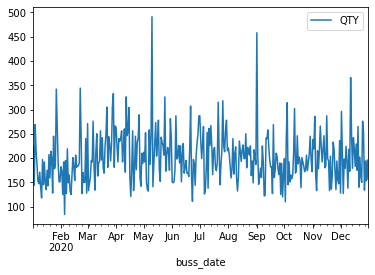

In [97]:
df[(df["site_id"]==120)&(df["pt_code"]==62)].iloc[-365:,:].set_index("buss_date").plot()

In [341]:
pd.pivot_table(df_time.groupby(["site_id","pt_code"]).sum("QTY").reset_index(),values="QTY", index="pt_code", columns="site_id", aggfunc='mean')

site_id        20        63        85        89       166
pt_code                                                  
62       381147.0  154621.0  435000.0  404771.0  468443.0
63       126315.0   94864.0  132049.0  200755.0  195004.0
214       76281.0   56219.0  122194.0  111520.0   86821.0
263       92061.0   64964.0  102852.0  147466.0   91117.0
1374      27980.0   12604.0   41888.0   59699.0   29776.0
1656      46127.0    7322.0   75119.0   49340.0   49025.0
2229      75589.0   19529.0   77317.0   73935.0   81818.0
3292      71476.0   16672.0   74002.0   77782.0   68227.0
12045     60226.0   40919.0   81056.0  109635.0   84965.0
13532     37365.0   12548.0   50526.0   64681.0   39520.0

In [231]:
df_time = pd.date_range("2018-01-01", "2020-12-31", freq='D')
df_time = pd.DataFrame({"Date":df_time})
df_time = df_time.merge(df[["site_id","pt_code"]].drop_duplicates(),how="cross")
df_time = df_time.merge(df, how="left",
              left_on=["Date","site_id","pt_code"],
              right_on = ["buss_date","site_id","pt_code"])
df_time = df_time.drop("buss_date",axis=1)
df_time["QTY"] = df_time["QTY"].fillna(0)
#df_time['QTY'] = np.log1p(df_time["QTY"].values)
df_time.head()

Date site_id pt_code    QTY
0 2018-01-01     120      62  261.0
1 2018-01-02     120      62  276.0
2 2018-01-03     120      62  315.0
3 2018-01-04     120      62  250.0
4 2018-01-05     120      62  210.0

In [232]:
def create_date_features(df):
    df.loc[:,'month'] = df.Date.dt.month
    df['day_of_month'] = df.Date.dt.day
    df['day_of_year'] = df.Date.dt.dayofyear
    df['week_of_year'] = df.Date.dt.weekofyear
    df.loc[:,'day_of_week'] = df.Date.dt.dayofweek
    df.loc[:,'year'] = df.Date.dt.year
    df.loc[:,"is_wknd"] = df.Date.dt.weekday // 4
    df.loc[:,'is_month_start'] = df.Date.dt.is_month_start.astype(int)
    df.loc[:,'is_month_end'] = df.Date.dt.is_month_end.astype(int)
    return df
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe.loc[:,'sales_lag_' + str(lag)] = dataframe.groupby(["site_id", "pt_code"])['QTY'].transform(
            lambda x: x.shift(lag))+random_noise(dataframe)
    return dataframe
# Random Noise
def random_noise(dataframe):
    return np.random.normal(dataframe["QTY"].mean(), size=(len(dataframe),))
# Rolling Mean Features
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe[('sales_roll_mean_' + str(window))] = dataframe.groupby(["site_id", "pt_code"])['QTY'].transform(lambda x: x.shift(14).rolling(window=window, min_periods=7, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe

# Exponentially Weighted Mean Features
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["site_id", "pt_code"])['QTY'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

def holiday(dataframe):
    start = dataframe["Date"].min().year
    end = dataframe["Date"].max().year+1
    years = [i for i in range (start,end)]


    df_holiday = pd.DataFrame(holidays.HK(years=years).items(),columns=["Date","Holiday_name"])

    CNYFilter = df_holiday["Holiday_name"].str.contains("Lunar")
    df_holiday.loc[CNYFilter,"CNY"]=1
    df_holiday.loc[~CNYFilter,"CNY"]=0
    df_holiday["Holiday"]=1
    df_holiday.loc[CNYFilter,"Holiday"]=0
    df_holiday["Date"] = df_holiday["Date"].astype("datetime64")
    df_holiday["CNY"] = df_holiday["CNY"].astype("int")
    df_holiday = df_holiday[["Date","CNY","Holiday"]]
    
    dataframe =  dataframe.merge(df_holiday,how="left",left_on="Date",right_on="Date")
    dataframe["CNY"] = dataframe["CNY"].fillna(0)
    dataframe["Holiday"] = dataframe["Holiday"].fillna(0)
    dataframe["CNY"] = dataframe["CNY"].astype("int")
    dataframe["Holiday"] = dataframe["Holiday"].astype("int")
    
    return dataframe
def Promotion(dataframe):
    promotion = pd.read_csv("promotion.CSV")
    promotion["Promotion start date"] = promotion["Promotion start date"].astype("datetime64")
    promotion["Promotion end date"] = promotion["Promotion end date"].astype("datetime64")
    promotion_df = pd.concat([pd.DataFrame({
                'Promotion_Date': pd.date_range(promotion["Promotion start date"][i], promotion["Promotion end date"][i], freq='D'),
                'Product': promotion["Product ID"][i],
                'product name': promotion["Product name"][i],
                #'Dep':promotion["Dept"][i],
                #'Cat':promotion["Cat"][i],
                #'Sub-cat':promotion["Sub-cat"][i],
                'Promotion (Y)':promotion["Promotion (Y)"][i],
                        }) 
                for i, row in promotion.iterrows()], ignore_index=True)
    promotion_df["Product"] = promotion_df["Product"].astype("category")
    dataframe = dataframe.merge(promotion_df, how="left",left_on=["Date","pt_code"], right_on=["Promotion_Date","Product"])
    dataframe = dataframe.drop("Product",axis=1)
    dataframe = dataframe.drop("Promotion_Date",axis=1)
    dataframe = dataframe.drop("product name",axis=1)
    dataframe["Promotion (Y)"] = dataframe["Promotion (Y)"].fillna(0)
    dataframe.loc[dataframe["Promotion (Y)"]=="Y","Promotion (Y)"]=1
    dataframe["pt_code"] =  dataframe["pt_code"].astype("category")
    dataframe["Promotion (Y)"] =  dataframe["Promotion (Y)"].astype("int")
    return dataframe

In [233]:
df_ff = pd.DataFrame()

In [234]:
#14 day
df_train = df_time[df_time["Date"]<="2020-12-22"]
#df_test = df_time[df_time["Date"]=="2020-12-14"]
#df_val = df_time[df_time["Date"]=="2020-12-23"]

lags =[7,14,21,28,29,30,31,60,61,90,92,
       121,137,160,180,364,365,366,367,368,369,370,371,372]
alphas = [0.95, 0.9, 0.8, 0.7, 0.5,0.4,0.3]
#create_date_features(df_train)
lag_features(df_train,lags)
#roll_mean_features(df_train, [14,21,28,120,365,730])
#ewm_features(df_train, alphas, lags)
#df_train = holiday(df_train)
#df_time = Promotion(df_time)
df_train = df_train.sort_values(["site_id","pt_code","Date"])
#df_train.dtypes

In [235]:
df_train = df_train[df_train["Date"]>"2020-01-01"]
df_test = df_train[(df_train["Date"]=="2020-12-18")]
df_train = df_train[df_train["Date"]<"2020-12-10"]

In [236]:
df_train.tail()

Date site_id pt_code    QTY  sales_lag_7  sales_lag_14  \
1069 2020-12-05     120      62  198.0   377.088589    356.232284   
1070 2020-12-06     120      62  179.0   368.001222    383.043366   
1071 2020-12-07     120      62  224.0   455.996936    454.864693   
1072 2020-12-08     120      62  193.0   347.348892    437.872407   
1073 2020-12-09     120      62  138.0   517.395777    395.316141   

      sales_lag_21  sales_lag_28  sales_lag_29  sales_lag_30  ...  \
1069    399.094057    399.254239    435.117579    352.927580  ...   
1070    404.340111    435.678880    397.879423    435.002676  ...   
1071    507.546925    487.758808    437.466320    399.431049  ...   
1072    420.661939    444.631999    487.527148    437.619469  ...   
1073    414.901040    412.260356    444.451588    488.459697  ...   

      sales_lag_180  sales_lag_364  sales_lag_365  sales_lag_366  \
1069     445.665302     440.135010     561.636916     546.979001   
1070     410.300119     399.543622     440.247535     558.913462   
1071     445.012901     399.109618     399.700839     439.788647   
1072     372.097918     381.255025     402.028525     398.323605   
1073     428.754025     458.280861     382.069755     399.891137   

      sales_lag_367  sales_lag_368  sales_lag_369  sales_lag_370  \
1069     390.065191     470.686349     362.599732     474.762219   
1070     545.288923     391.237989     468.835936     362.165961   
1071     561.121667     547.678887     391.136994     471.192901   
1072     439.238745     559.575381     547.266547     392.427253   
1073     397.847860     439.579466     559.478288     546.858108   

      sales_lag_371  sales_lag_372  
1069     498.242269     402.442789  
1070     475.647742     498.585721  
1071     362.310903     475.555746  
1072     469.349958     362.676430  
1073     391.445610     469.737669  

[5 rows x 28 columns]

In [237]:
X_train = df_train.drop("QTY",axis=1).iloc[:,1:]
y_train = df_train["QTY"]
X_test = df_test.drop("QTY",axis=1).iloc[:,1:]
y_test  = df_test["QTY"]

In [238]:
FEATURES = X_train.columns
TARGET = "QTY"

In [239]:
X_test

site_id pt_code  sales_lag_7  sales_lag_14  sales_lag_21  sales_lag_28  \
1082     120      62   394.050123    347.407144    416.403522    424.170355   

      sales_lag_29  sales_lag_30  sales_lag_31  sales_lag_60  ...  \
1082    353.787306    416.890357    419.960925     359.70846  ...   

      sales_lag_180  sales_lag_364  sales_lag_365  sales_lag_366  \
1082     526.727855     739.905157     561.688785     510.378095   

      sales_lag_367  sales_lag_368  sales_lag_369  sales_lag_370  \
1082     386.628589     350.910607     500.375465      431.34525   

      sales_lag_371  sales_lag_372  
1082     478.529503     368.094837  

[1 rows x 26 columns]

In [240]:
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
model = XGBRegressor(n_estimators=1000,
                     learning_rate=0.02,
                     max_depth=7,
                     max_bin=512,
                     early_stopping_rounds=200,
                     enable_categorical=True,
                     tree_method="hist",
                     #metric=mean_squared_error,
                     min_child_weight=3.049217092991447,
                     reg_alpha=0.10573374420174517,
                     reg_lambda=0.005384806967638617                    
                    )
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train),(X_test,y_test)],
          verbose=100
         )

[0]	validation_0-rmse:202.79885	validation_1-rmse:224.43400
[100]	validation_0-rmse:34.00708	validation_1-rmse:46.76232
[200]	validation_0-rmse:13.54789	validation_1-rmse:31.40660
[300]	validation_0-rmse:9.04957	validation_1-rmse:27.92072
[400]	validation_0-rmse:6.71696	validation_1-rmse:28.00867
[500]	validation_0-rmse:5.02820	validation_1-rmse:28.58708
[547]	validation_0-rmse:4.42939	validation_1-rmse:27.97148


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=200, enable_categorical=True,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.02, max_bin=512, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0,
             min_child_weight=3.049217092991447, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.10573374420174517, reg_lambda=0.005384806967638617, ...)

In [241]:
y_test.values

array([229.])

In [243]:
yhat = model.predict(X_test)
yhat

array([201.6514], dtype=float32)

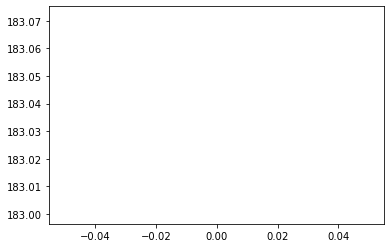

In [226]:
yhat = model.predict(X_test)
plt.plot(yhat)
plt.plot(y_test.values)

In [107]:
model.best_score

56.652461750016855

In [70]:
model_lgb.best_score_

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('rmse', 17.866150590733085)]),
             'valid_1': OrderedDict([('rmse', 24.83643614331095)])})

In [225]:
yhat = model.predict(X_test)

In [74]:
df_final = df_test[["Date","site_id","pt_code"]]
df_final.loc[:,("yhat")] = yhat
df_final.loc[:,("ylgb")] =y_lgb
#df_final.loc[:,("QTY")] = y_test.values
df_final = df_final.merge(df,how="left", left_on=["Date","site_id","pt_code"],right_on=["buss_date","site_id","pt_code"])

In [77]:
# MAPE function
def MAPE(df):
    df =df.dropna()
    df = df[df["QTY"]>0]
    df = df.set_index(["site_id","pt_code"]).sort_index()
    sliceIndex = df.index.unique()
    value = 0
    print(df.shape)
    df["MAPE"]=np.abs((df["QTY"]-df["yhat"])/df["QTY"])
    MAPE_indi=[]
    return np.mean(df["MAPE"])
MAPE_value = MAPE(df_final)
MAPE_value

(619, 5)


0.2070875273922394

In [78]:
rmse = mean_squared_error(y_test, yhat,squared=False)

In [79]:
df_ff=pd.DataFrame()
df_ff = pd.concat([df_ff,df_final])

In [80]:
df_final["MAPE"]=np.abs((df_final["QTY"]-df_final["yhat"])/df_final["QTY"])
#df_final[df_final["QTY"]>1].mean()

In [81]:
df_final.sort_values("MAPE",ascending=False).head(30)

Date site_id pt_code        yhat        ylgb  buss_date    QTY  \
249 2020-12-20      63   13532    3.201744    4.148012 2020-12-20    1.0   
193 2020-12-20      63    1374    2.995140    3.387152 2020-12-20    1.0   
208 2020-12-21      63    1656   11.897396   12.337865 2020-12-21    4.0   
629 2020-12-22     166   13532   75.605171   64.201243 2020-12-22   28.0   
130 2020-12-13      63      62  106.311279  113.202920 2020-12-13   41.0   
374 2020-12-19      85   13532   62.650822   56.587008 2020-12-19   26.0   
251 2020-12-22      63   13532   14.396889   12.502931 2020-12-22    6.0   
620 2020-12-13     166   13532   62.829380   57.239464 2020-12-13   28.0   
369 2020-12-14      85   13532   63.629528   62.250633 2020-12-14   29.0   
127 2020-12-10      63      62  121.813164  110.185876 2020-12-10   58.0   
377 2020-12-22      85   13532   72.660301   73.465973 2020-12-22   35.0   
375 2020-12-20      85   13532   57.460121   56.267832 2020-12-20   28.0   
116 2020-12-13      20   13532   40.052185   39.952619 2020-12-13   20.0   
373 2020-12-18      85   13532   61.453175   54.562161 2020-12-18   31.0   
387 2020-12-18      89      62  305.924530  307.078957 2020-12-18  155.0   
624 2020-12-17     166   13532   67.979630   60.269289 2020-12-17   35.0   
201 2020-12-14      63    1656   17.384808   16.636517 2020-12-14    9.0   
113 2020-12-10      20   13532   37.720669   41.347165 2020-12-10   20.0   
138 2020-12-21      63      62   79.932198   82.056061 2020-12-21   43.0   
372 2020-12-17      85   13532   66.627228   54.258011 2020-12-17   36.0   
622 2020-12-15     166   13532   68.568581   59.382438 2020-12-15   38.0   
203 2020-12-16      63    1656   12.496487   11.078790 2020-12-16    7.0   
625 2020-12-18     166   13532   73.100868   65.608369 2020-12-18   41.0   
289 2020-12-18      85     214   96.066444   90.862593 2020-12-18   54.0   
367 2020-12-12      85   13532   52.653114   47.405552 2020-12-12   30.0   
628 2020-12-21     166   13532   72.783066   66.425825 2020-12-21   42.0   
54  2020-12-21      20     263   80.856544   84.843522 2020-12-21   47.0   
82  2020-12-21      20    1656   59.562511   60.517343 2020-12-21   35.0   
593 2020-12-14     166    2229   76.209213   67.858818 2020-12-14   45.0   
250 2020-12-21      63   13532   16.813004   14.777765 2020-12-21   10.0   

         MAPE  
249  2.201744  
193  1.995140  
208  1.974349  
629  1.700185  
130  1.592958  
374  1.409647  
251  1.399481  
620  1.243906  
369  1.194122  
127  1.100227  
377  1.076009  
375  1.052147  
116  1.002609  
373  0.982360  
387  0.973707  
624  0.942275  
201  0.931645  
113  0.886033  
138  0.858888  
372  0.850756  
622  0.804436  
203  0.785212  
625  0.782948  
289  0.779008  
367  0.755104  
628  0.732930  
54   0.720352  
82   0.701786  
593  0.693538  
250  0.681300

In [84]:
# MAPE function
def MAPE(df):
    df =df.dropna()
    df = df[df["QTY"]>0]
    df = df.set_index(["site_id","pt_code"]).sort_index()
    sliceIndex = df.index.unique()
    value = 0
    #print(sliceIndex)
    df["MAPE"]=np.abs((df["QTY"]-df["yhat"])/df["QTY"])
    MAPE_indi=[]
    for i in sliceIndex:   
        temp = df.loc[i].groupby(["site_id","pt_code"]).sum()/df.loc[i].shape[0]
        #print(df.loc[i].groupby(["site_id","pt_code"]).sum())
        value = value+ temp['MAPE'].mean()
        MAPE_indi.append(temp['MAPE'].mean())
    return value/sliceIndex.shape[0],pd.Series(MAPE_indi)
MAPE_value,MAPE_indi = MAPE(df_ff)
MAPE_value

0.2077657595697222

In [85]:
df_final.sort_values(["Date"])

Date site_id pt_code        yhat        ylgb  buss_date    QTY  \
0   2020-12-09      20      62  284.004059  275.004893 2020-12-09  353.0   
154 2020-12-09      63     214   64.058800   59.507180 2020-12-09  113.0   
462 2020-12-09      89    2229   64.136467   61.350309 2020-12-09   93.0   
140 2020-12-09      63      63  125.248436  111.749617 2020-12-09  124.0   
476 2020-12-09      89   12045  102.720001  100.739621 2020-12-09  106.0   
..         ...     ...     ...         ...         ...        ...    ...   
139 2020-12-22      63      62   78.145241   74.572358 2020-12-22   61.0   
293 2020-12-22      85     214  101.601540   97.594555 2020-12-22   63.0   
153 2020-12-22      63      63  122.307472  112.734938 2020-12-22  141.0   
587 2020-12-22     166    1656   65.823059   67.627386 2020-12-22   50.0   
629 2020-12-22     166   13532   75.605171   64.201243 2020-12-22   28.0   

         MAPE  
0    0.195456  
154  0.433108  
462  0.310361  
140  0.010068  
476  0.030943  
..        ...  
139  0.281070  
293  0.612723  
153  0.132571  
587  0.316461  
629  1.700185  

[630 rows x 8 columns]

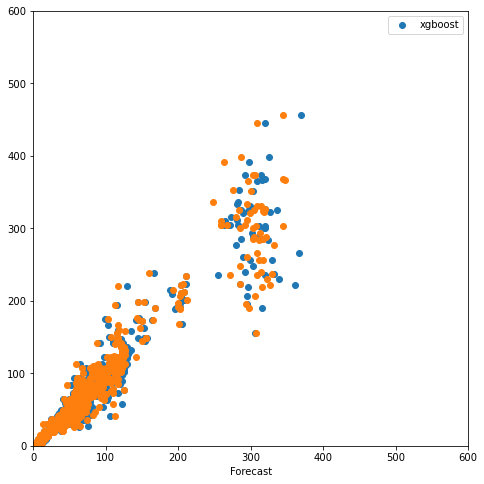

In [88]:
#plt.scatter(yhat,y_test)
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect("equal")
ax.set_xlim(0,600,50)
ax.set_xlabel("Forecast")
ax.set_ylim(0,600,50)
scatter = plt.scatter(df_final["yhat"],df_final["QTY"],label="xgboost")
scatter = plt.scatter(df_final["ylgb"],df_final["QTY"])
plt.legend()
#plt.legend(*scatter.legend_elements())
plt.show()

In [14]:
fi.sort_values('importance',ascending=False)

NameError: name 'fi' is not defined

<AxesSubplot:>

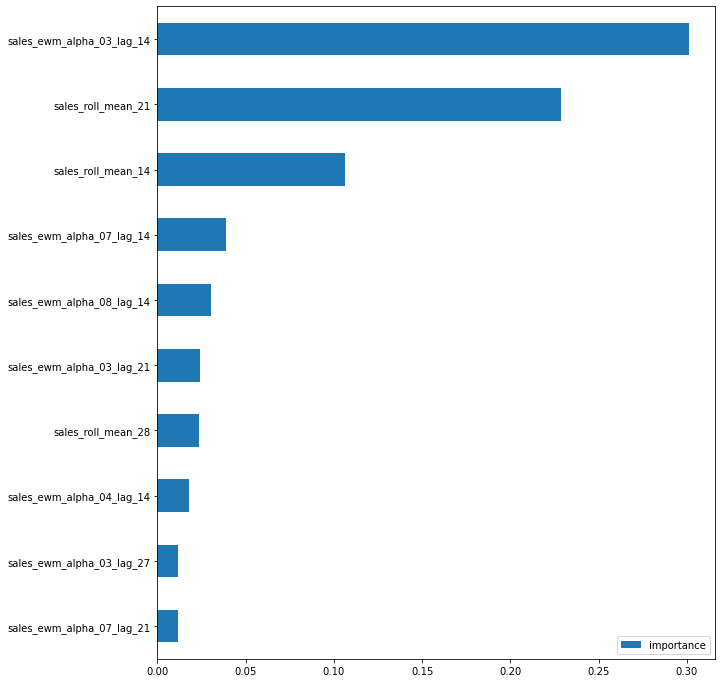

In [352]:
fi = pd.DataFrame(data = model.feature_importances_,
             index = model.feature_names_in_,
             columns = ["importance"])
fi.sort_values('importance',ascending=False).iloc[:10,:].sort_values('importance').plot(kind='barh',figsize=(10,12))

/var/folders/_0/ycth_cf923q232q48fh0mbl80000gn/T/ipykernel_44346/4052016043.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,6))


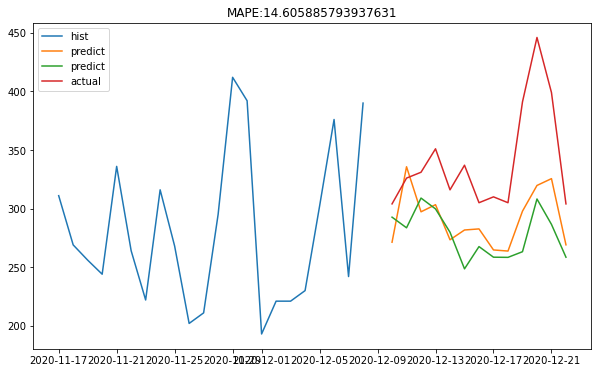

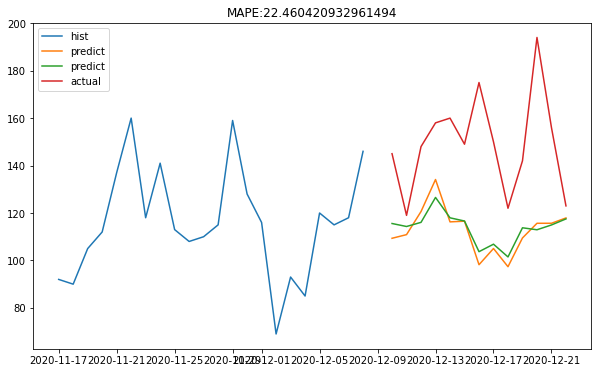

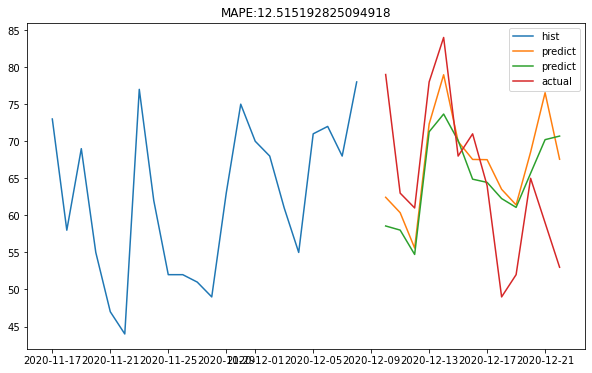

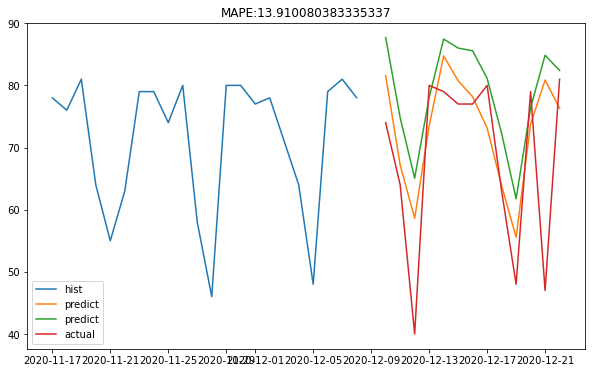

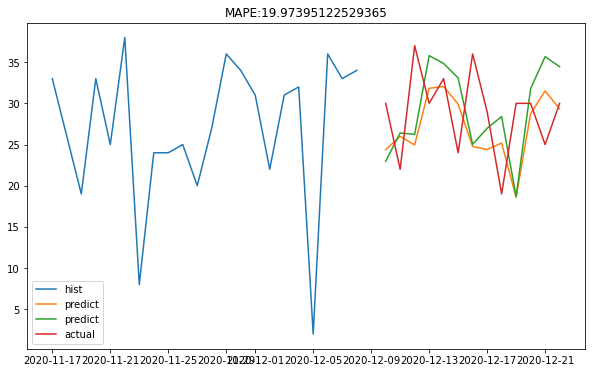

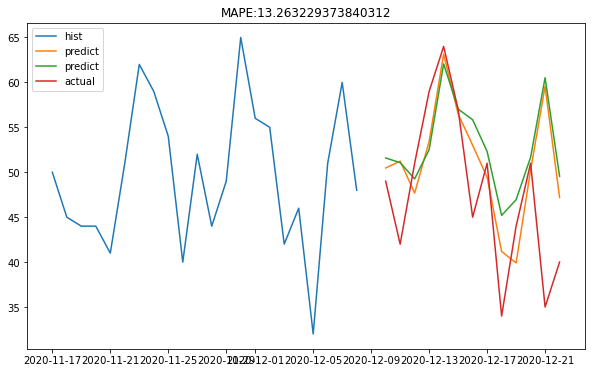

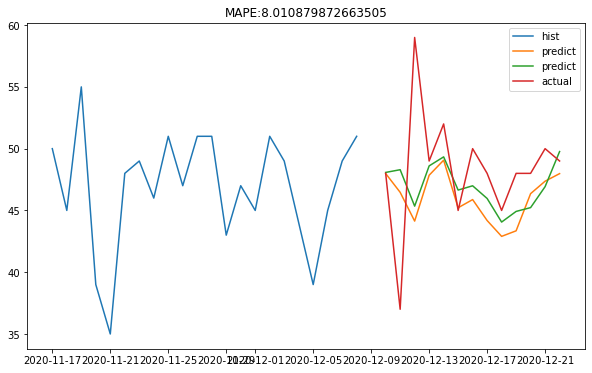

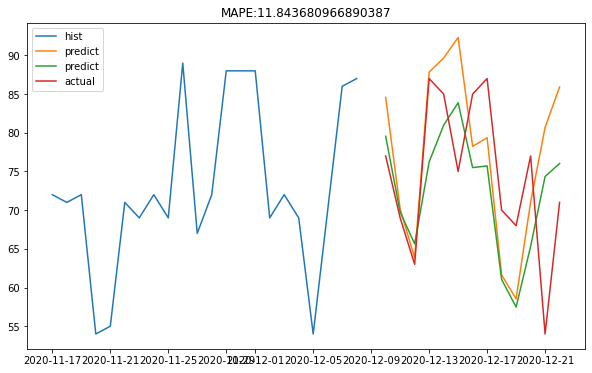

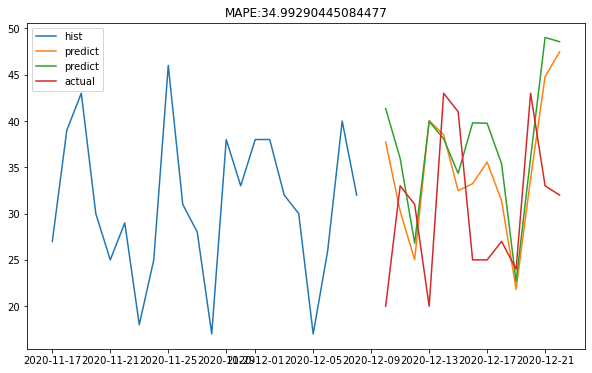

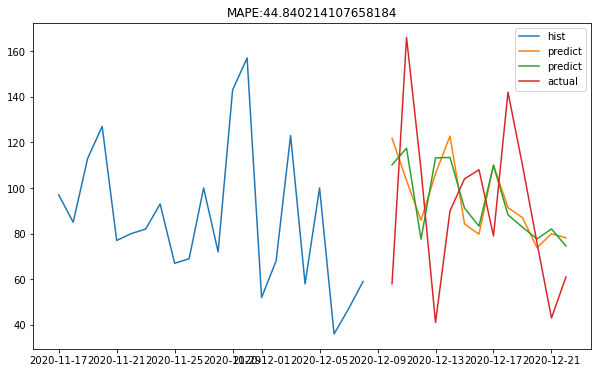

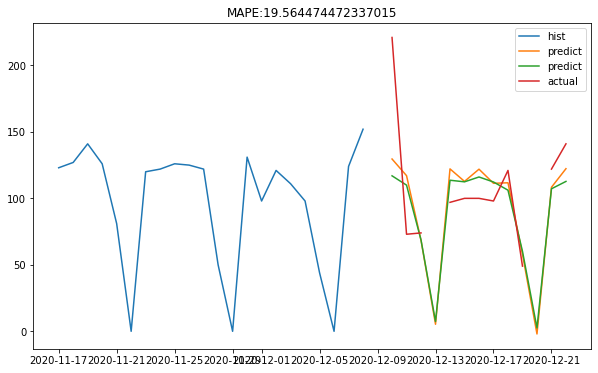

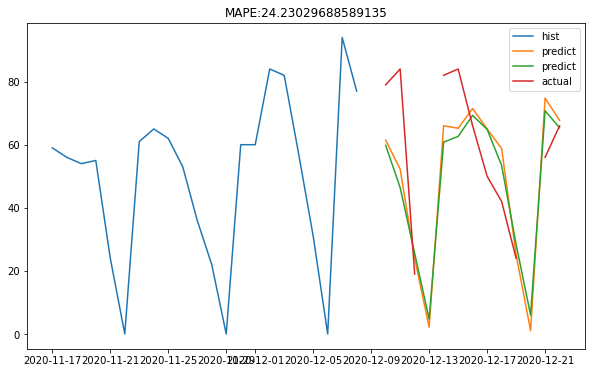

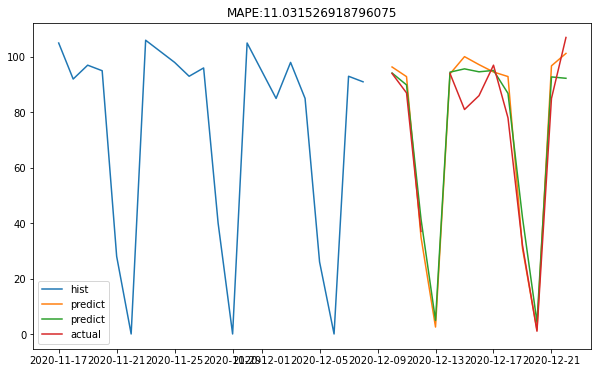

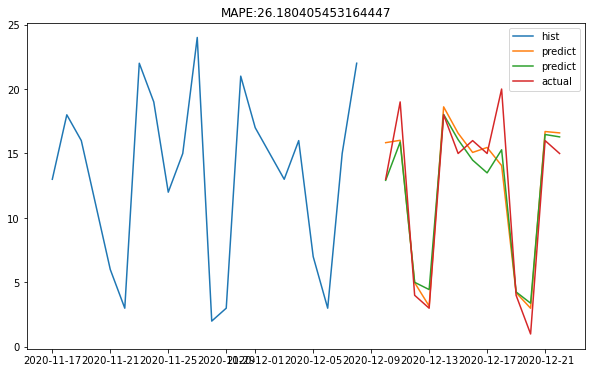

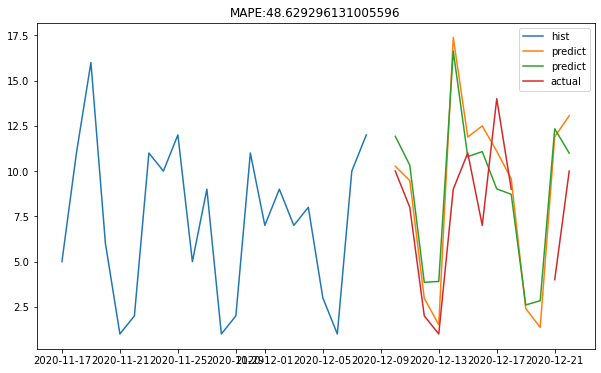

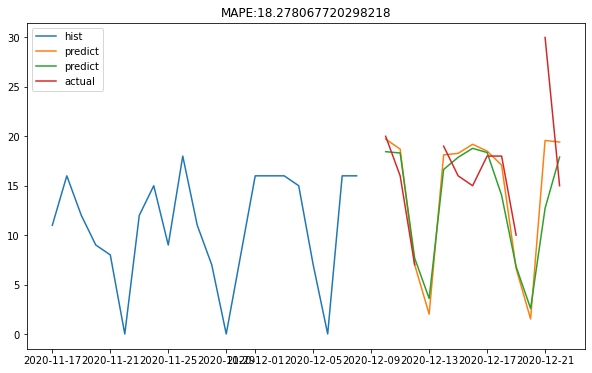

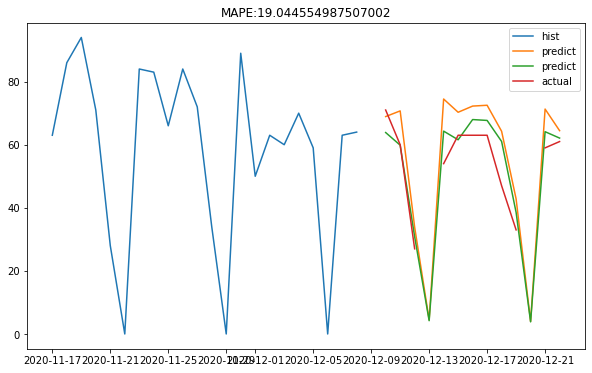

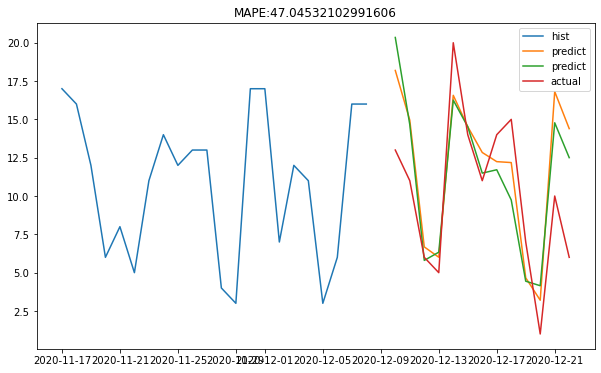

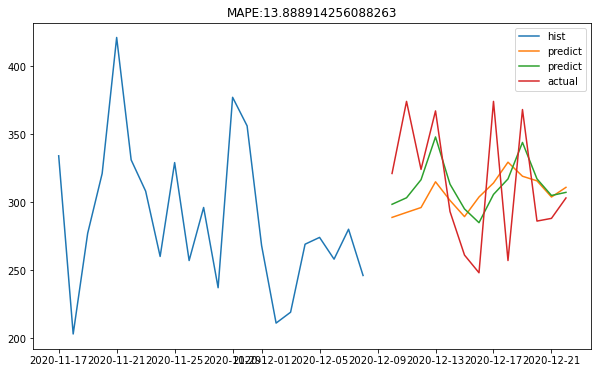

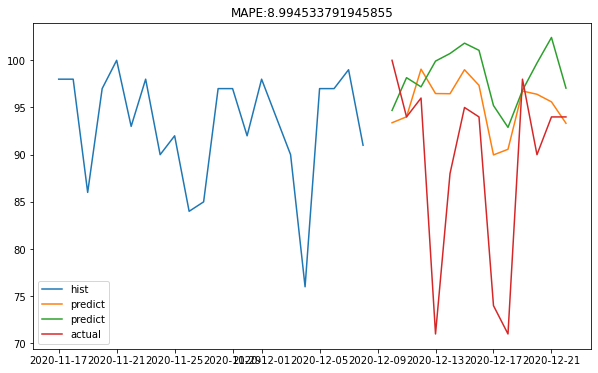

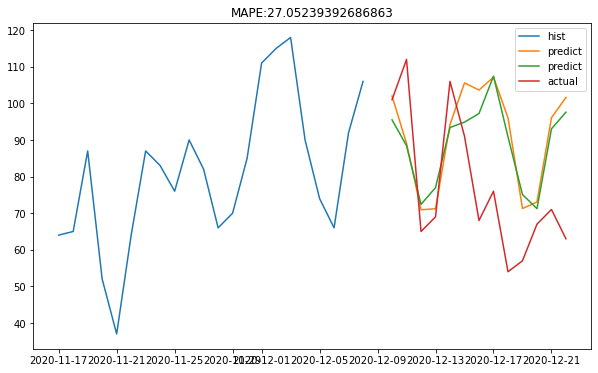

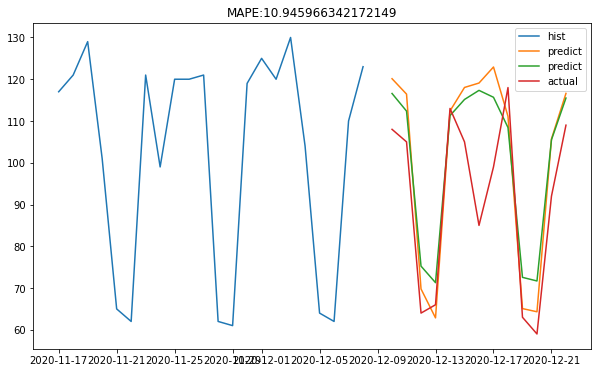

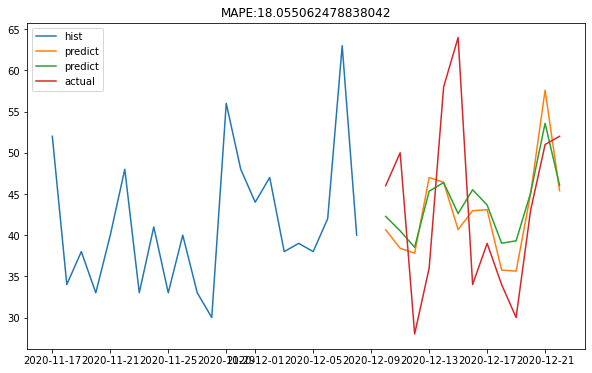

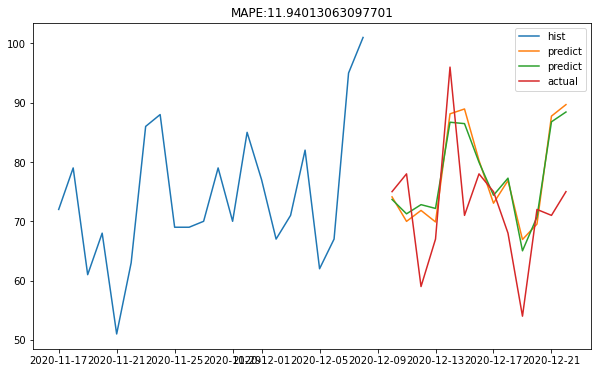

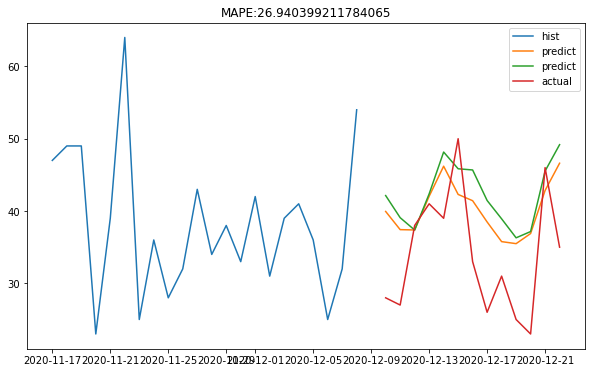

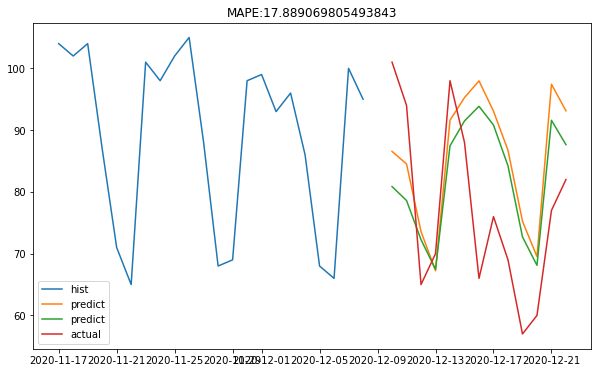

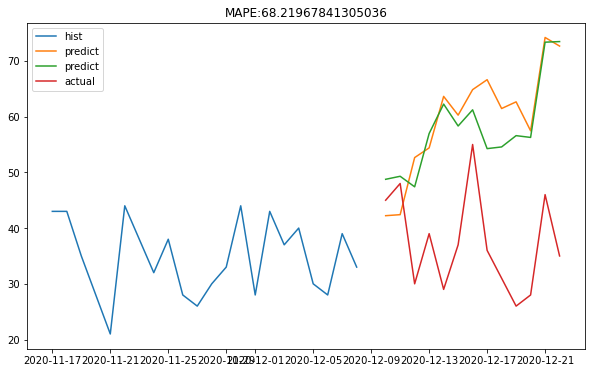

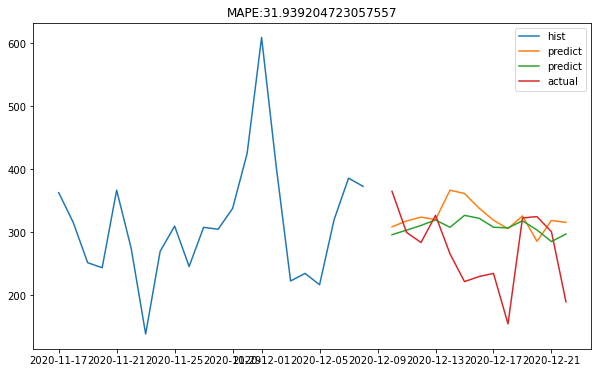

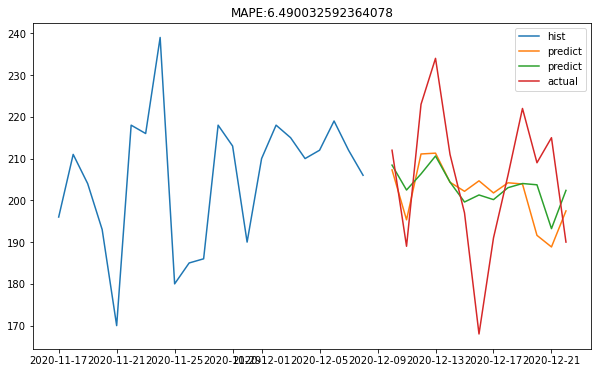

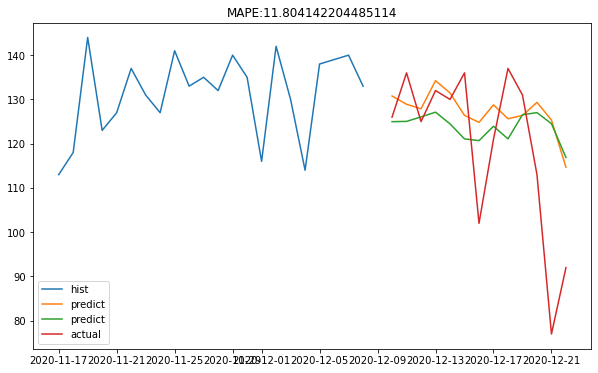

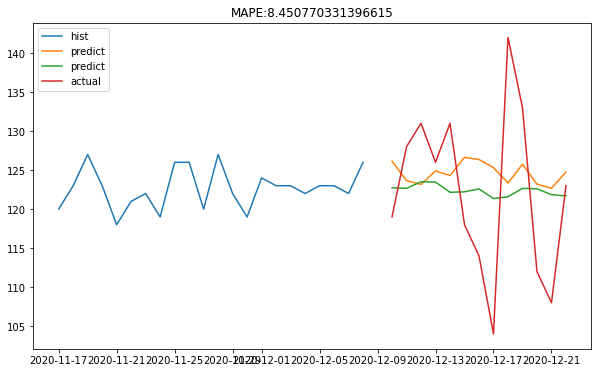

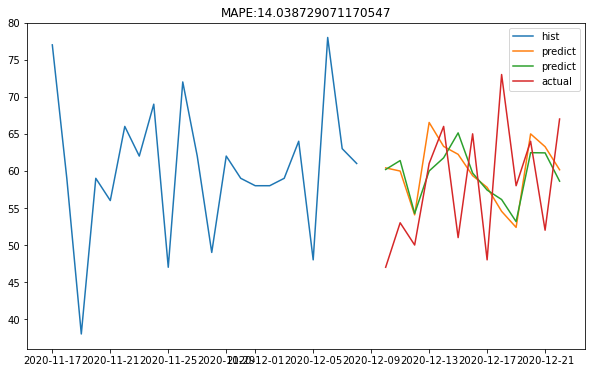

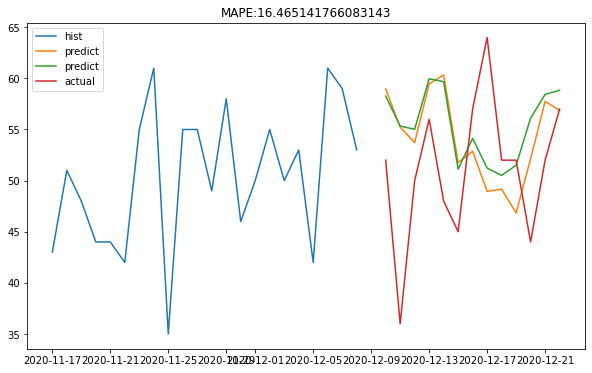

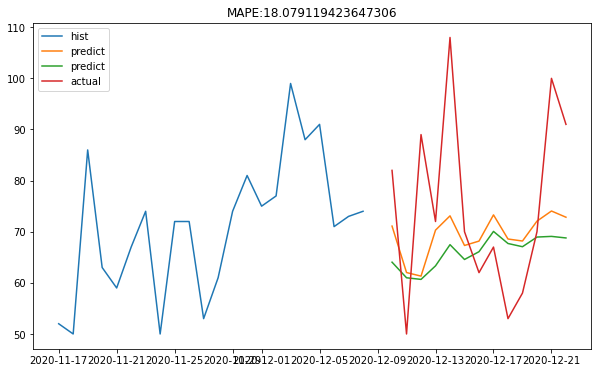

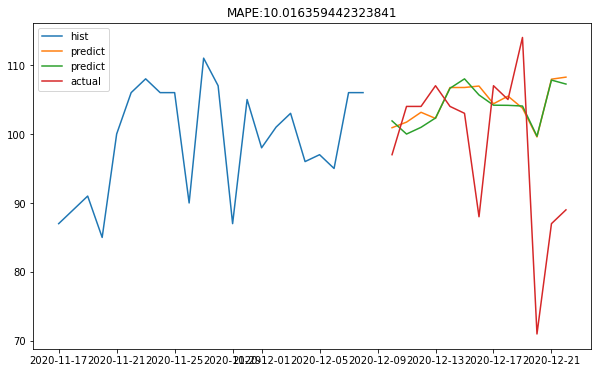

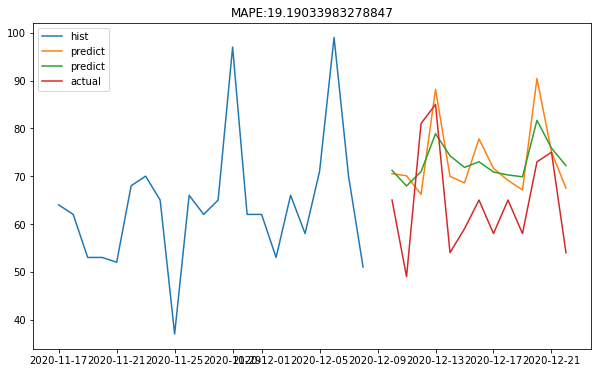

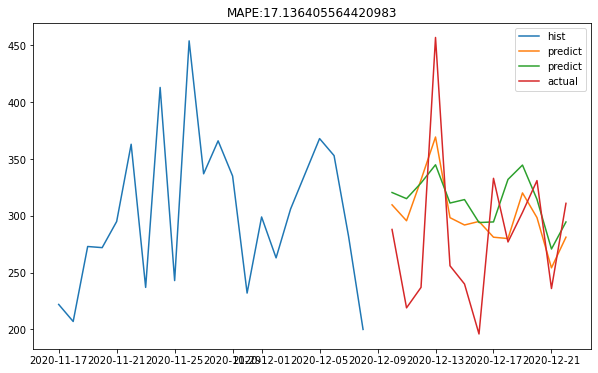

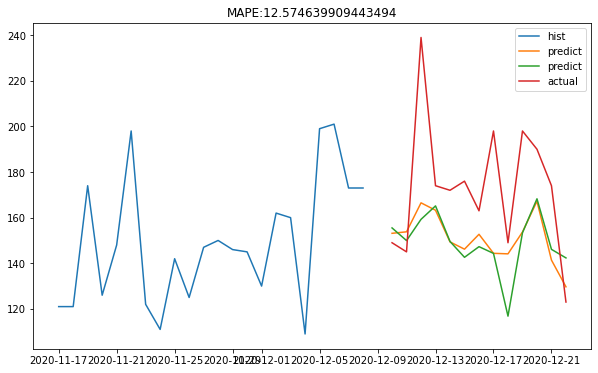

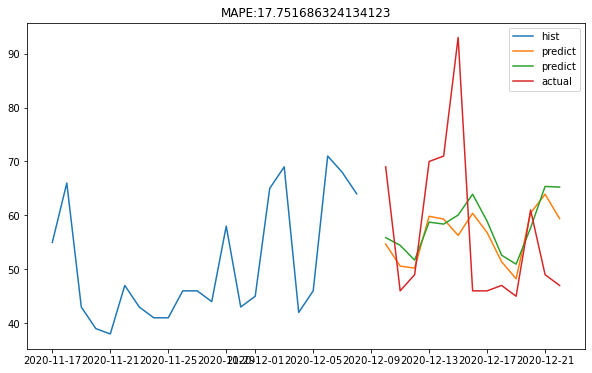

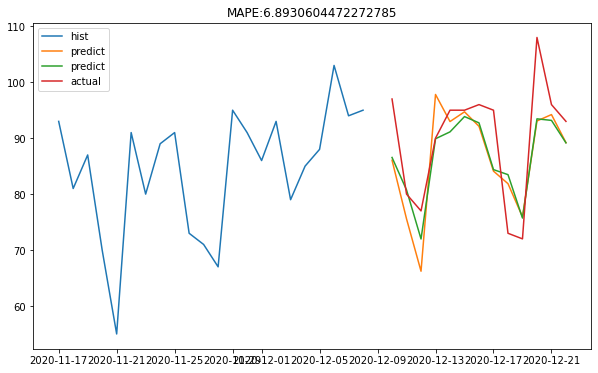

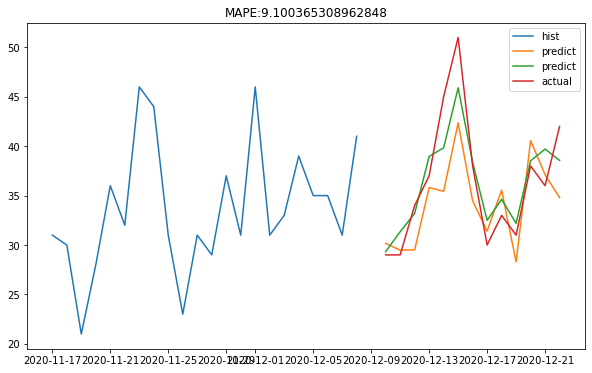

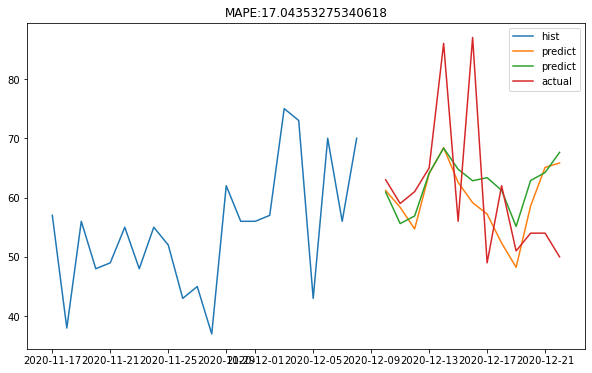

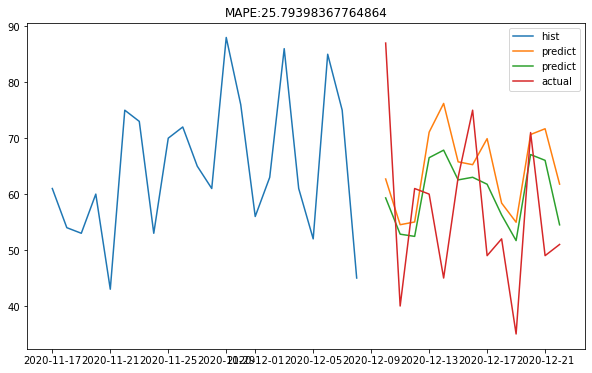

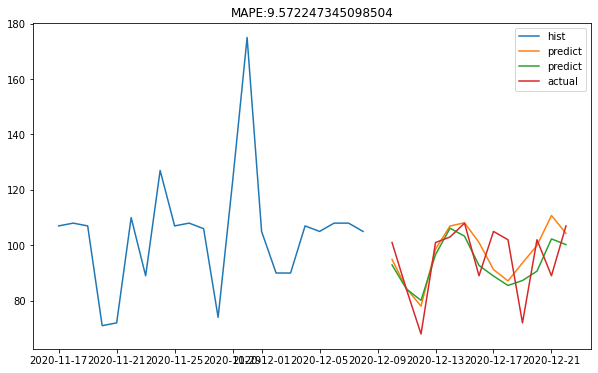

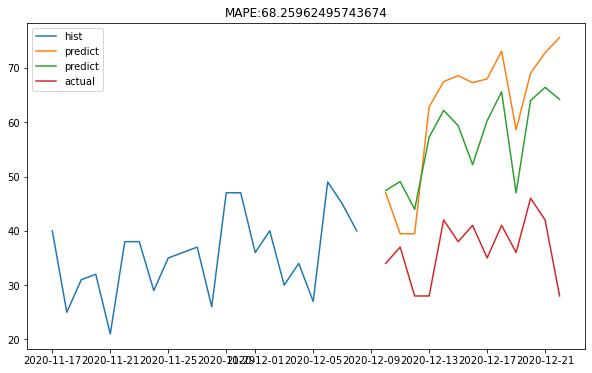

In [89]:
hist = df_train[df_train["Date"]>"2020-11-15"]
for i in range(45):
    plt.figure(figsize=(10,6))
    plt.plot(hist["Date"][i*23+1:i*23+23],hist['QTY'][i*23+1:i*23+23],label="hist")
    plt.plot(df_final["Date"][i*14+1:i*14+14],df_final['yhat'][i*14+1:i*14+14],label="predict")
    plt.plot(df_final["Date"][i*14+1:i*14+14],df_final['ylgb'][i*14+1:i*14+14],label="predict")
    plt.plot(df_final["Date"][i*14+1:i*14+14],df_final['QTY'][i*14+1:i*14+14],label="actual")
    plt.title("MAPE:" + str(MAPE_indi[i]*100))
    plt.legend()

In [175]:
!pip install --upgrade xgboost

## Feature Engineering

In [365]:
def create_date_features(df):
    df['month'] = df.Date.dt.month
    #df['day_of_month'] = df.Date.dt.day
    #df['day_of_year'] = df.Date.dt.dayofyear
    #df['week_of_year'] = df.Date.dt.weekofyear
    df['day_of_week'] = df.Date.dt.dayofweek
    df['year'] = df.Date.dt.year
    df["is_wknd"] = df.Date.dt.weekday // 4
    df['is_month_start'] = df.Date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.Date.dt.is_month_end.astype(int)
    return df
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe.loc[:,'sales_lag_' + str(lag)] = dataframe.groupby(["site_id", "pt_code"])['QTY'].transform(
            lambda x: x.shift(lag))
        #random_noise(dataframe)
    return dataframe
# Random Noise
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))
# Rolling Mean Features
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["site_id", "pt_code"])['QTY']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=7, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe
# Exponentially Weighted Mean Features
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["site_id", "pt_code"])['QTY'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

def holiday(dataframe):
    start = dataframe["Date"].min().year
    end = dataframe["Date"].max().year+1
    years = [i for i in range (start,end)]


    df_holiday = pd.DataFrame(holidays.HK(years=years).items(),columns=["Date","Holiday_name"])

    CNYFilter = df_holiday["Holiday_name"].str.contains("Lunar")
    df_holiday.loc[CNYFilter,"CNY"]=1
    df_holiday.loc[~CNYFilter,"CNY"]=0
    df_holiday["Holiday"]=1
    df_holiday.loc[CNYFilter,"Holiday"]=0
    df_holiday["Date"] = df_holiday["Date"].astype("datetime64")
    df_holiday["CNY"] = df_holiday["CNY"].astype("int")
    df_holiday = df_holiday[["Date","CNY","Holiday"]]
    
    dataframe =  dataframe.merge(df_holiday,how="left",left_on="Date",right_on="Date")
    dataframe["CNY"] = dataframe["CNY"].fillna(0)
    dataframe["Holiday"] = dataframe["Holiday"].fillna(0)
    dataframe["CNY"] = dataframe["CNY"].astype("int")
    dataframe["Holiday"] = dataframe["Holiday"].astype("int")
    
    return dataframe
def Promotion(dataframe):
    promotion = pd.read_csv("promotion.CSV")
    promotion["Promotion start date"] = promotion["Promotion start date"].astype("datetime64")
    promotion["Promotion end date"] = promotion["Promotion end date"].astype("datetime64")
    promotion_df = pd.concat([pd.DataFrame({
                'Promotion_Date': pd.date_range(promotion["Promotion start date"][i], promotion["Promotion end date"][i], freq='D'),
                'Product': promotion["Product ID"][i],
                'product name': promotion["Product name"][i],
                #'Dep':promotion["Dept"][i],
                #'Cat':promotion["Cat"][i],
                #'Sub-cat':promotion["Sub-cat"][i],
                'Promotion (Y)':promotion["Promotion (Y)"][i],
                        }) 
                for i, row in promotion.iterrows()], ignore_index=True)
    promotion_df["Product"] = promotion_df["Product"].astype("category")
    dataframe = dataframe.merge(promotion_df, how="left",left_on=["Date","pt_code"], right_on=["Promotion_Date","Product"])
    dataframe = dataframe.drop("Product",axis=1)
    dataframe = dataframe.drop("Promotion_Date",axis=1)
    dataframe = dataframe.drop("product name",axis=1)
    dataframe["Promotion (Y)"] = dataframe["Promotion (Y)"].fillna(0)
    dataframe.loc[dataframe["Promotion (Y)"]=="Y","Promotion (Y)"]=1
    dataframe["pt_code"] =  dataframe["pt_code"].astype("category")
    dataframe["Promotion (Y)"] =  dataframe["Promotion (Y)"].astype("int")
    return dataframe

In [347]:
df_train

Date site_id pt_code   QTY
0     2018-01-01      20   12045  71.0
1     2018-01-01      20   13532  37.0
2     2018-01-01      20    1374  27.0
3     2018-01-01      20    1656  55.0
4     2018-01-01      20     214  84.0
...          ...     ...     ...   ...
54195 2020-12-19      63    3292   0.0
54196 2020-12-19      63      63  49.0
54197 2020-12-19      20    3292  61.0
54198 2020-12-19      85    3292  16.0
54199 2020-12-19     166    3292  47.0

[54200 rows x 4 columns]

In [321]:
lags =[13,14,15,16,17,18,28,30,61,121, 137,180,365]
alphas = [0.95, 0.9, 0.8, 0.7, 0.5,0.4]
#lags =[1, 2, 3,4,5,6,7,21,28]
#lags =[1, 2, 3,4,]
#alphas = [0.9, 0.8]
create_date_features(df_time)
lag_features(df_time,lags)
#roll_mean_features(df_time, [12,13,14,18,21,30,365])
ewm_features(df_time, alphas, lags)
df_time = holiday(df_time)
#df_time = Promotion(df_time)
df_time = df_time.sort_values(["site_id","pt_code","Date"])
df_time.dtypes

Date                          datetime64[ns]
site_id                             category
pt_code                             category
QTY                                  float64
month                                  int64
                                   ...      
sales_ewm_alpha_04_lag_137           float64
sales_ewm_alpha_04_lag_180           float64
sales_ewm_alpha_04_lag_365           float64
CNY                                    int64
Holiday                                int64
Length: 103, dtype: object

<AxesSubplot:xlabel='Holiday', ylabel='QTY'>

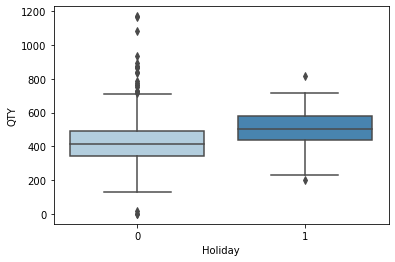

In [322]:
import seaborn as sns
filt = (df_time["site_id"]==166) & (df_time["pt_code"]==62)
sns.boxplot(data=df_time[filt], x='Holiday',y='QTY', palette='Blues')

In [323]:
#df_time = pd.get_dummies(df_time, columns=['site_id','pt_code'])

In [324]:
df_time = df_time[df_time["Date"]>="2019-01-01"]

## Split training Set

In [325]:
train_t = pd.to_datetime("2020-11-02")
test_t = train_t+pd.Timedelta(12, "d")
val_t = test_t+pd.Timedelta(12, "d")

In [326]:
#split train and validation
filt_train = (df_time["Date"]<train_t)
filt_test = (df_time["Date"]>= train_t) & (df_time["Date"]< test_t)
filt_val = (df_time["Date"]>=test_t) & (df_time["Date"]< val_t)
df1_train = df_time[filt_train]
df1_test = df_time[filt_test]
df1_val = df_time[filt_val]

In [327]:
X_train = df1_train.drop("QTY",axis=1).iloc[:,1:]
y_train = df1_train["QTY"]
X_test = df1_test.drop("QTY",axis=1).iloc[:,1:]
y_test  = df1_test["QTY"]
X_val = df1_val.drop("QTY",axis=1).iloc[:,1:]
y_val  = df1_val["QTY"]

In [328]:
FEATURES = X_train.columns
TARGET = "QTY"

## Model Training

In [330]:
# Custom Cost Function
def smape(preds, target):
    n = len(preds)
    masked_arr = ~(target==0)
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val
def xgb_smape(preds, train_data):    
    #labels = train_data.get_label()
    smape_val = smape(preds,train_data)
    return 'SMAPE', smape_val, False

In [331]:
from xgboost import XGBRegressor

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
model = XGBRegressor(n_estimators=3000,
                     learning_rate=0.01,
                      early_stopping_rounds=100,
                     enable_categorical=True,
                     tree_method="hist",
                     metric=mean_squared_error,
                    )
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train),(X_test,y_test)],
          verbose=100
         )

<AxesSubplot:>

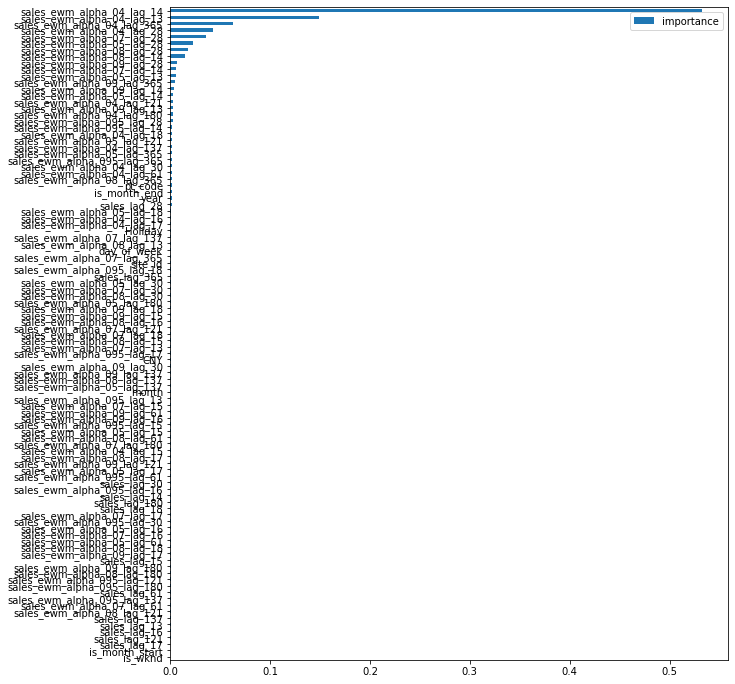

In [333]:
fi = pd.DataFrame(data = model.feature_importances_,
             index = model.feature_names_in_,
             columns = ["importance"])
fi.sort_values('importance').plot(kind='barh',figsize=(10,12))

In [334]:
#X_val = X_test
#y_val = y_test

In [335]:
filt_val = (df_time["Date"]>=test_t+pd.Timedelta(0,'day')) & (df_time["Date"]< val_t+pd.Timedelta(0,'day'))
df1_val = df_time[filt_val]
X_val = df1_val.drop("QTY",axis=1).iloc[:,1:]
y_val  = df1_val["QTY"]

In [336]:
yhat = model.predict(X_val)

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:323: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]


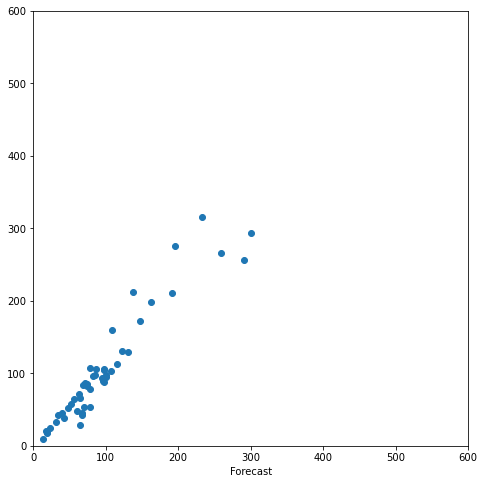

In [407]:
#plt.scatter(yhat,y_test)
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect("equal")
ax.set_xlim(0,600,50)
ax.set_xlabel("Forecast")
ax.set_ylim(0,600,50)
scatter = plt.scatter(yhat,y_test)
#plt.legend(*scatter.legend_elements())
plt.show()

In [338]:
df_final = df1_val[["Date","site_id","pt_code"]]
df_final.loc[:,("yhat")] = yhat
df_final.loc[:,("QTY")] = y_val.values

/var/folders/_0/ycth_cf923q232q48fh0mbl80000gn/T/ipykernel_34744/3367211263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.loc[:,("yhat")] = yhat
/var/folders/_0/ycth_cf923q232q48fh0mbl80000gn/T/ipykernel_34744/3367211263.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.loc[:,("QTY")] = y_val.values


In [315]:
df_train[df_train["Date"]>"2020-11-15"].head(24)

Date site_id pt_code    QTY  month  day_of_month  week_of_year  \
52507 2020-11-16      20      62  300.0     11            16            47   
52557 2020-11-17      20      62  311.0     11            17            47   
52607 2020-11-18      20      62  269.0     11            18            47   
52657 2020-11-19      20      62  256.0     11            19            47   
52707 2020-11-20      20      62  244.0     11            20            47   
52757 2020-11-21      20      62  336.0     11            21            47   
52807 2020-11-22      20      62  264.0     11            22            47   
52857 2020-11-23      20      62  222.0     11            23            48   
52907 2020-11-24      20      62  316.0     11            24            48   
52957 2020-11-25      20      62  268.0     11            25            48   
53007 2020-11-26      20      62  202.0     11            26            48   
53057 2020-11-27      20      62  211.0     11            27            48   
53107 2020-11-28      20      62  295.0     11            28            48   
53157 2020-11-29      20      62  412.0     11            29            48   
53207 2020-11-30      20      62  392.0     11            30            49   
53257 2020-12-01      20      62  193.0     12             1            49   
53307 2020-12-02      20      62  221.0     12             2            49   
53357 2020-12-03      20      62  221.0     12             3            49   
53407 2020-12-04      20      62  230.0     12             4            49   
53457 2020-12-05      20      62  302.0     12             5            49   
53507 2020-12-06      20      62  376.0     12             6            49   
53557 2020-12-07      20      62  242.0     12             7            50   
53607 2020-12-08      20      62  390.0     12             8            50   
52508 2020-11-16      20      63  111.0     11            16            47   

       day_of_week  year  is_wknd  ...  sales_ewm_alpha_03_lag_368  \
52507            0  2020        0  ...                  371.091195   
52557            1  2020        0  ...                  335.963836   
52607            2  2020        0  ...                  318.874685   
52657            3  2020        0  ...                  345.612280   
52707            4  2020        1  ...                  328.928596   
52757            5  2020        1  ...                  327.450017   
52807            6  2020        1  ...                  285.015012   
52857            0  2020        0  ...                  288.610508   
52907            1  2020        0  ...                  289.027356   
52957            2  2020        0  ...                  294.719149   
53007            3  2020        0  ...                  335.303404   
53057            4  2020        1  ...                  305.812383   
53107            5  2020        1  ...                  272.568668   
53157            6  2020        1  ...                  306.898068   
53207            0  2020        0  ...                  268.228647   
53257            1  2020        0  ...                  254.060053   
53307            2  2020        0  ...                  265.442037   
53357            3  2020        0  ...                  289.309426   
53407            4  2020        1  ...                  263.116598   
53457            5  2020        1  ...                  249.281619   
53507            6  2020        1  ...                  235.097133   
53557            0  2020        0  ...                  210.767993   
53607            1  2020        0  ...                  217.137595   
52508            0  2020        0  ...                  111.556270   

       sales_ewm_alpha_03_lag_369  sales_ewm_alpha_03_lag_370  \
52507                  364.273135                  322.818765   
52557                  371.091195                  364.273135   
52607                  335.963836                  371.091195   
52657                  318.874685                 

In [340]:
# MAPE function
def MAPE(df):
    df =df.dropna()
    df = df[df["QTY"]>0]
    df = df.set_index(["site_id","pt_code"]).sort_index()
    sliceIndex = df.index.unique()
    value = 0
    #print(sliceIndex)
    df["MAPE"]=np.abs((df["QTY"]-df["yhat"])/df["QTY"])
    MAPE_indi=[]
    for i in sliceIndex:   
        temp = df.loc[i].groupby(["site_id","pt_code"]).sum()/df.loc[i].shape[0]
        #print(df.loc[i].groupby(["site_id","pt_code"]).sum())
        value = value+ temp['MAPE'].mean()
        MAPE_indi.append(temp['MAPE'].mean())
    return value/sliceIndex.shape[0],pd.Series(MAPE_indi)
MAPE_value,MAPE_indi = MAPE(df_final)
MAPE_value

0.2855655682985304

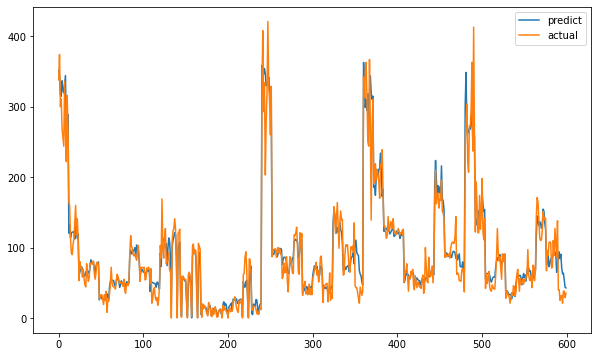

In [313]:
plt.figure(figsize=(10,6))
plt.plot(yhat,label="predict")
plt.plot(y_val.values,label="actual")
plt.legend()

In [305]:
df_final

Date site_id pt_code        yhat  buss_date    QTY      MAPE
0   2020-12-09      20      62  283.594849 2020-12-09  353.0  0.196615
1   2020-12-10      20      62  312.392242 2020-12-10  304.0  0.027606
2   2020-12-11      20      62  311.609344 2020-12-11  326.0  0.044143
3   2020-12-12      20      62  319.898407 2020-12-12  331.0  0.033540
4   2020-12-13      20      62  316.940460 2020-12-13  351.0  0.097036
..         ...     ...     ...         ...        ...    ...       ...
695 2020-12-18     166   13532   54.248535 2020-12-18   41.0  0.323135
696 2020-12-19     166   13532   53.036999 2020-12-19   36.0  0.473250
697 2020-12-20     166   13532   67.656464 2020-12-20   46.0  0.470793
698 2020-12-21     166   13532   61.917477 2020-12-21   42.0  0.474226
699 2020-12-22     166   13532   66.525360 2020-12-22   28.0  1.375906

[700 rows x 7 columns]

/var/folders/_0/ycth_cf923q232q48fh0mbl80000gn/T/ipykernel_13067/3508649016.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,6))


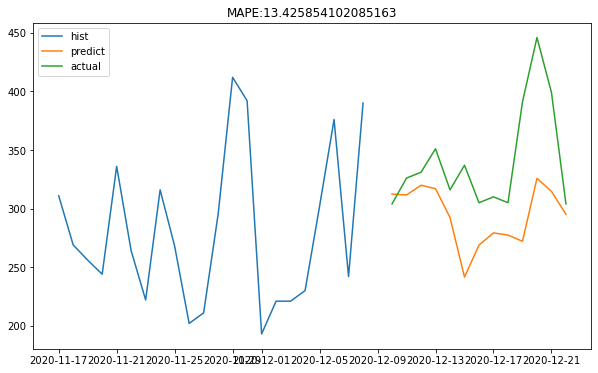

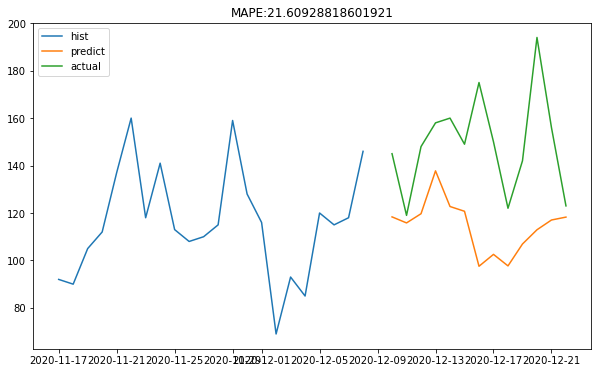

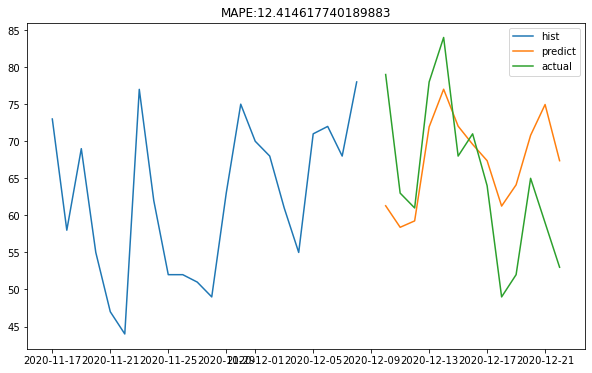

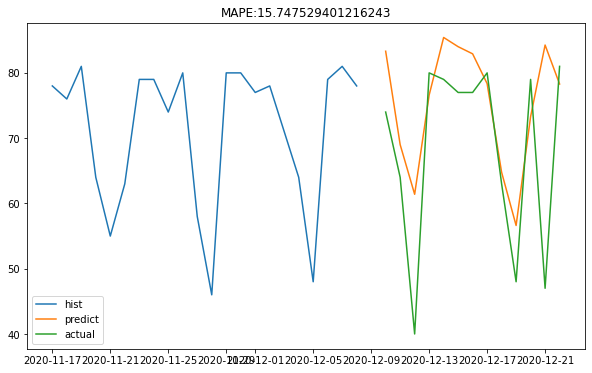

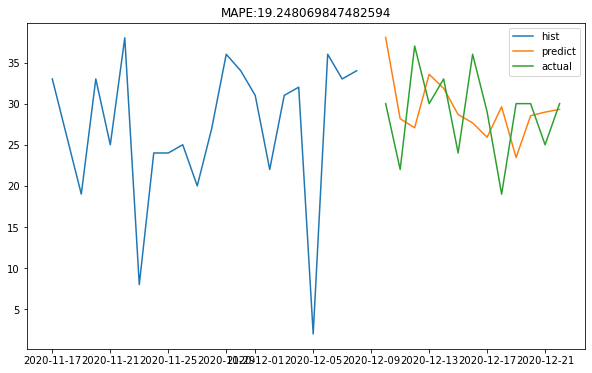

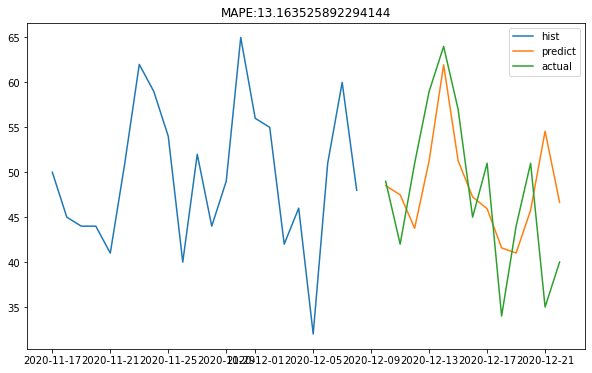

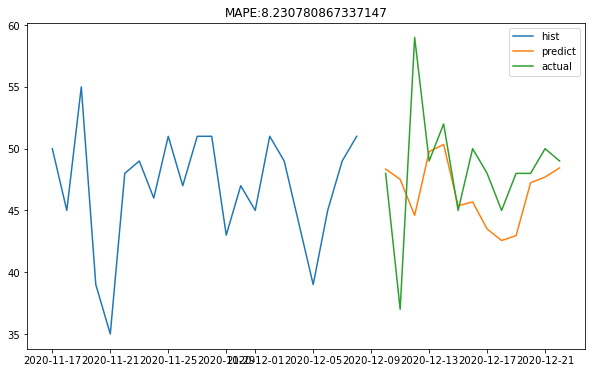

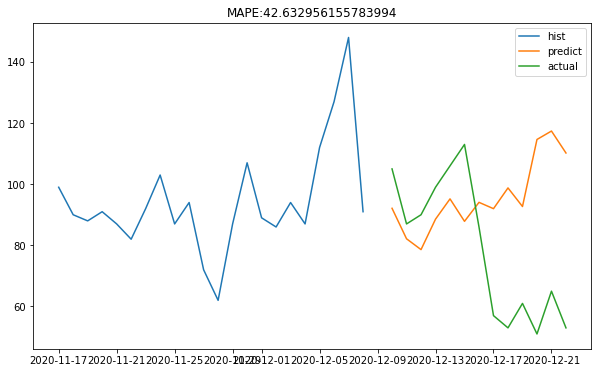

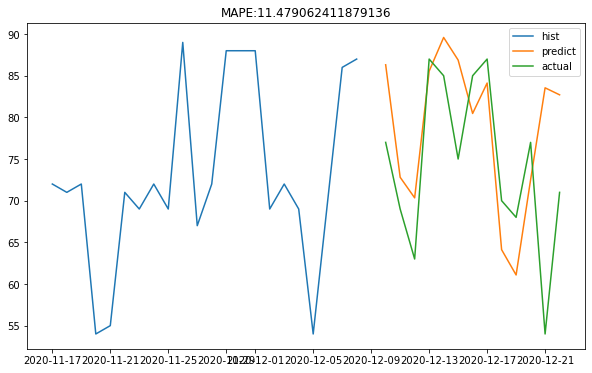

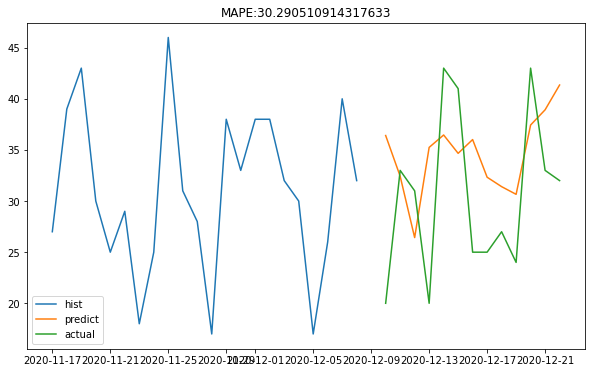

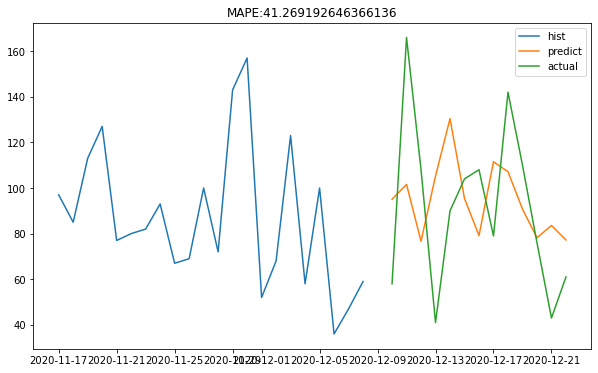

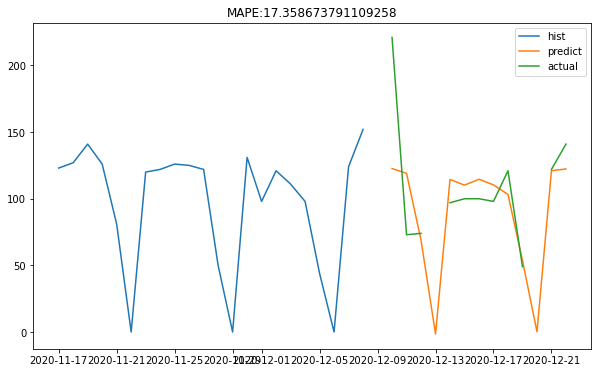

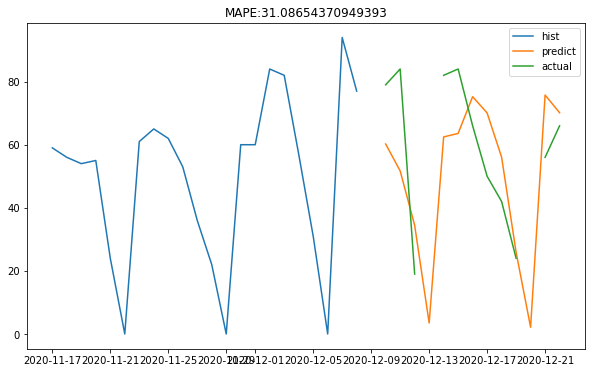

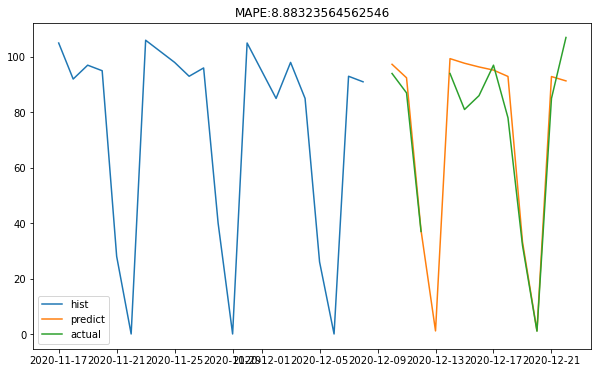

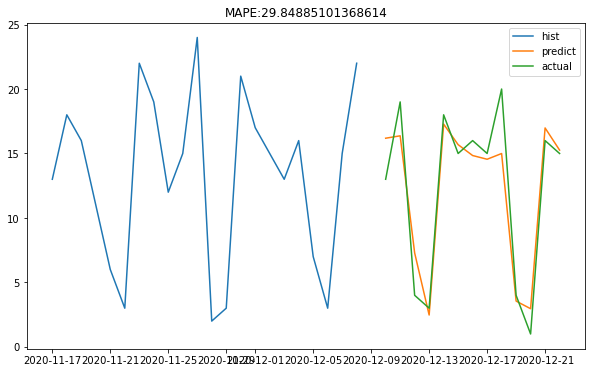

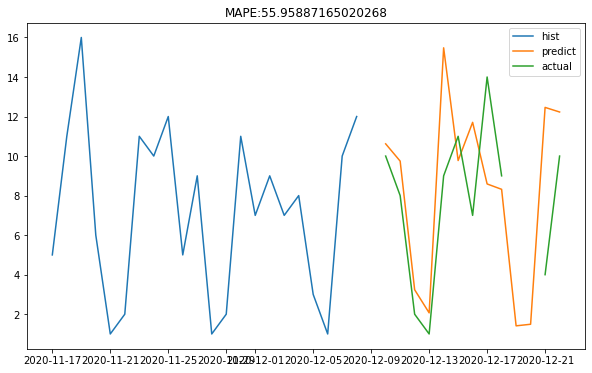

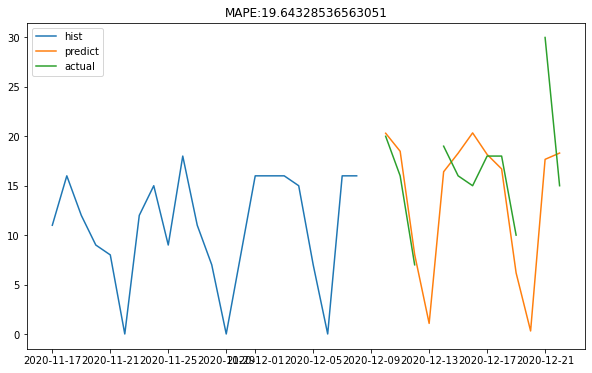

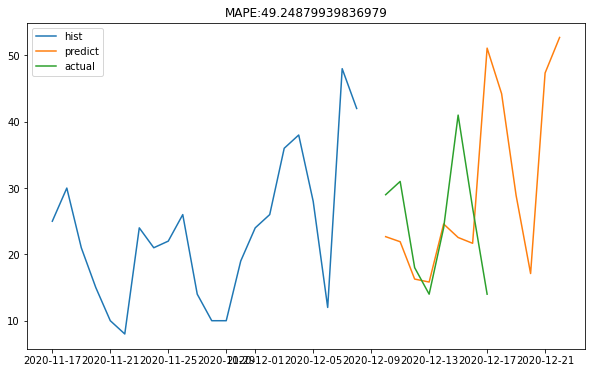

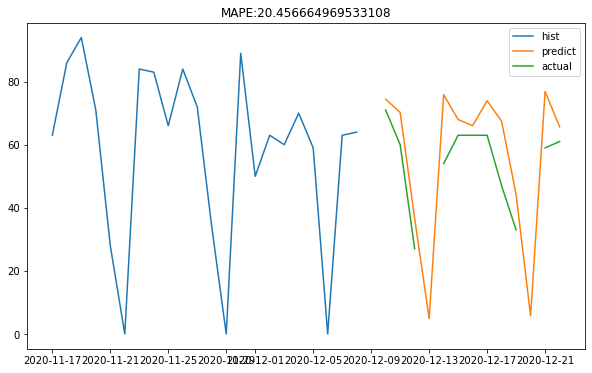

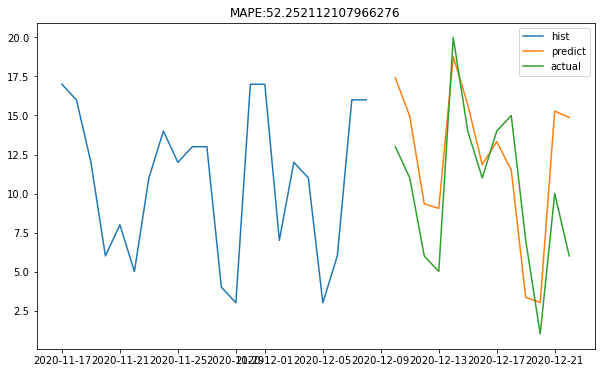

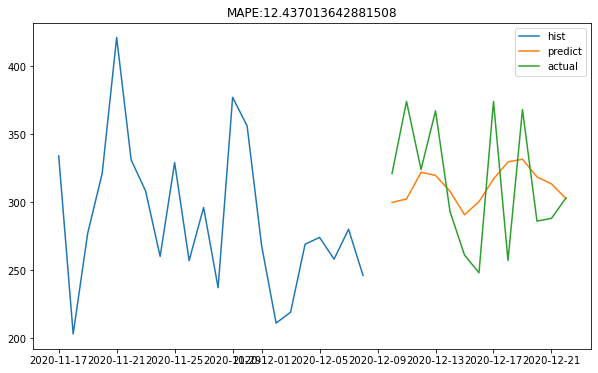

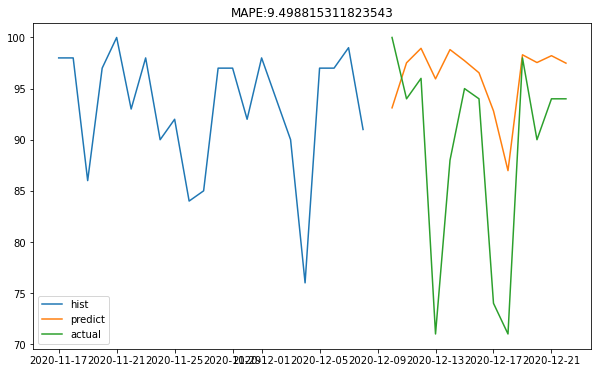

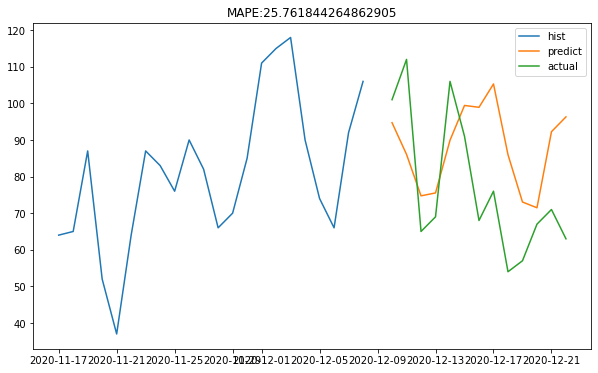

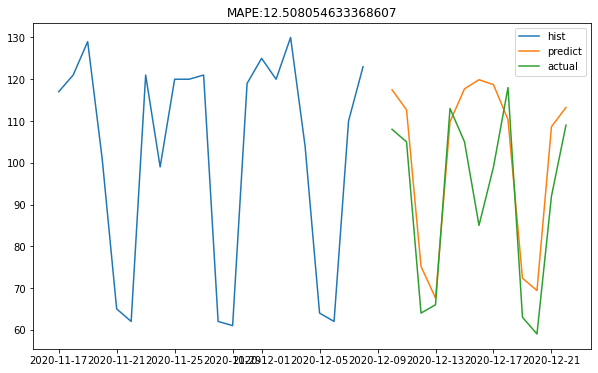

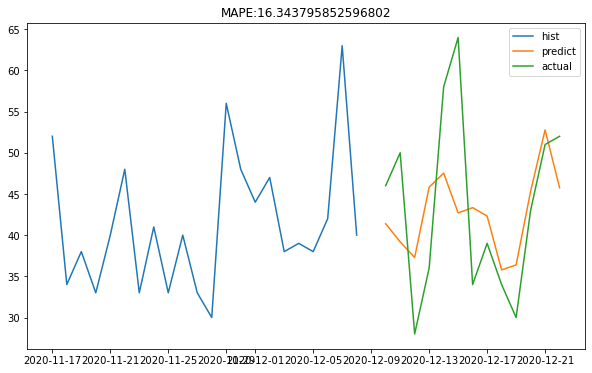

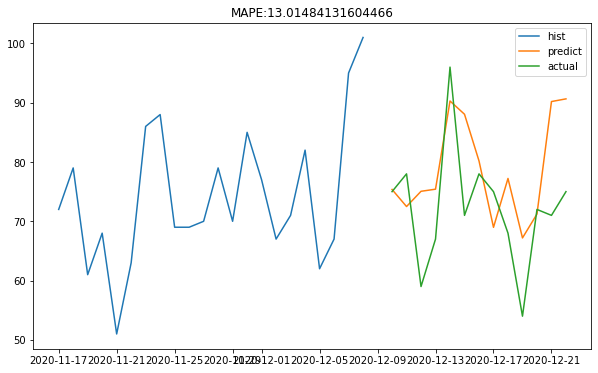

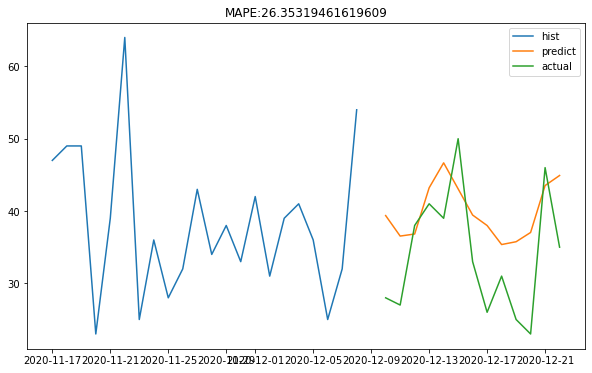

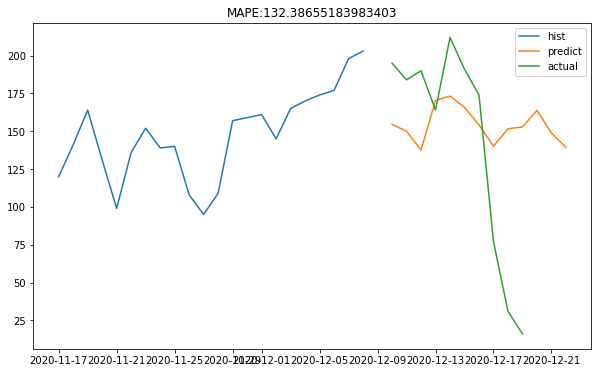

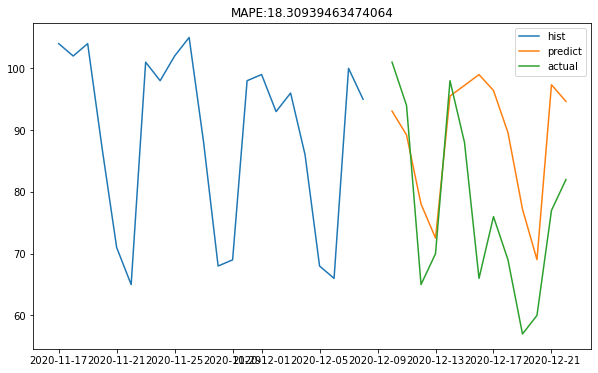

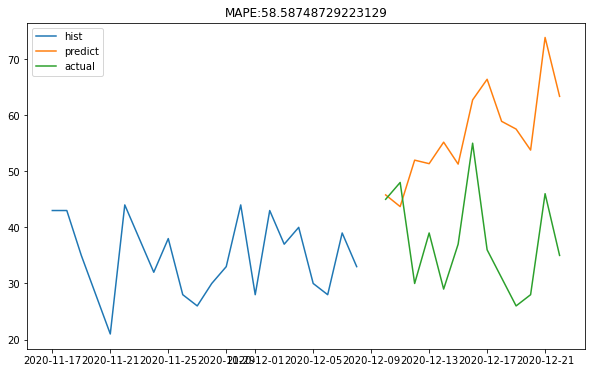

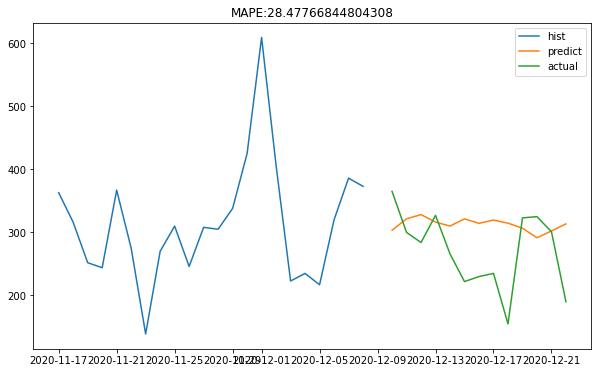

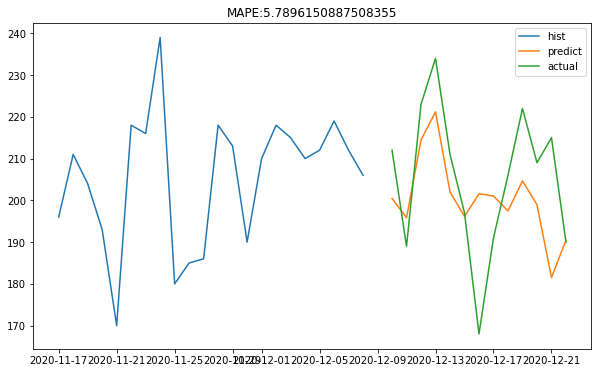

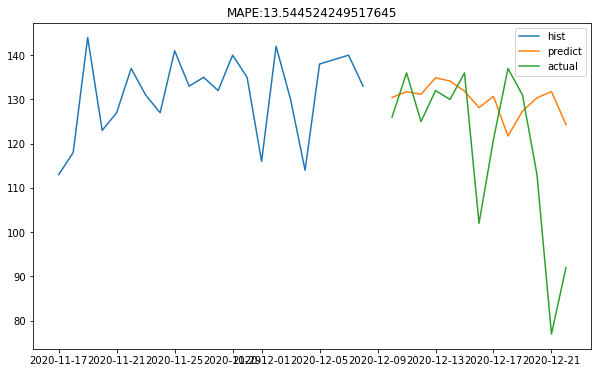

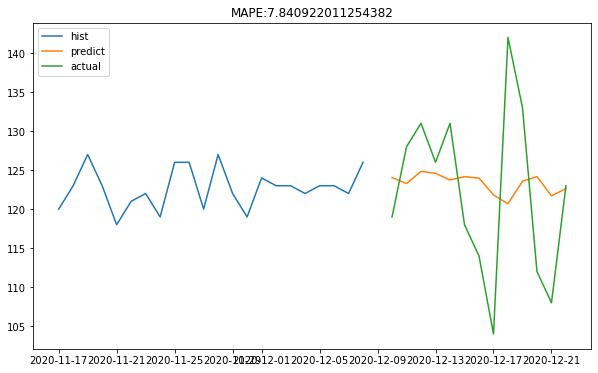

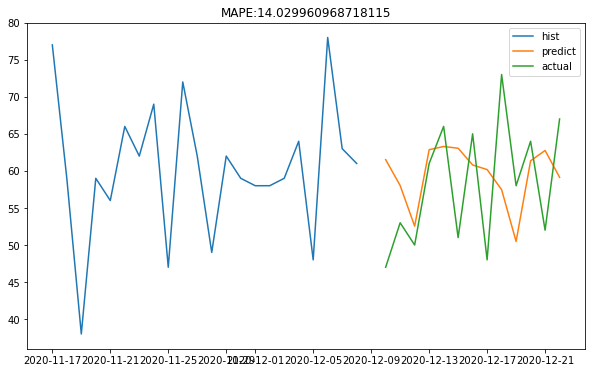

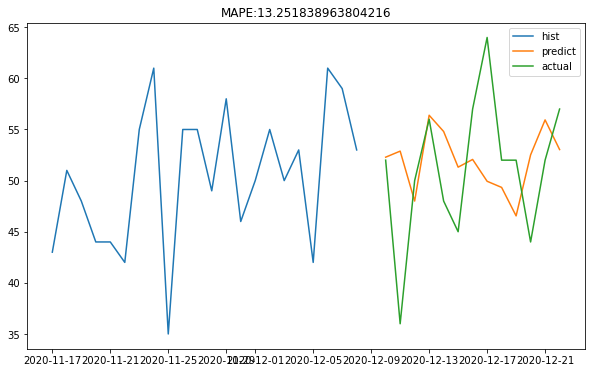

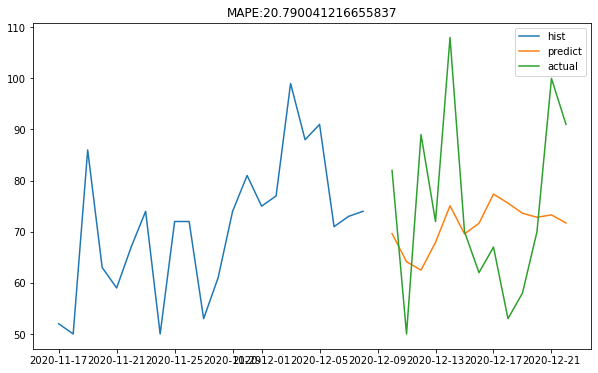

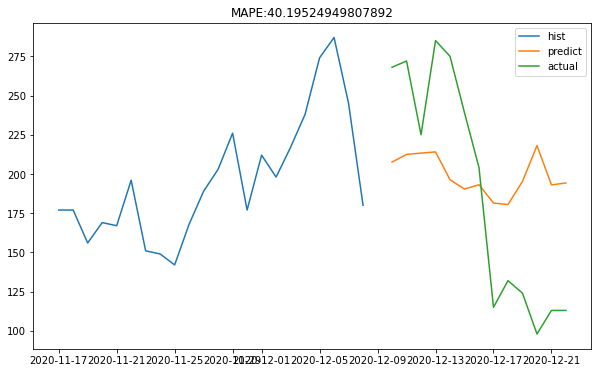

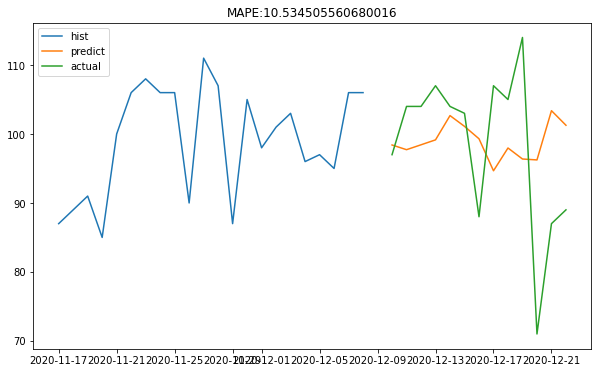

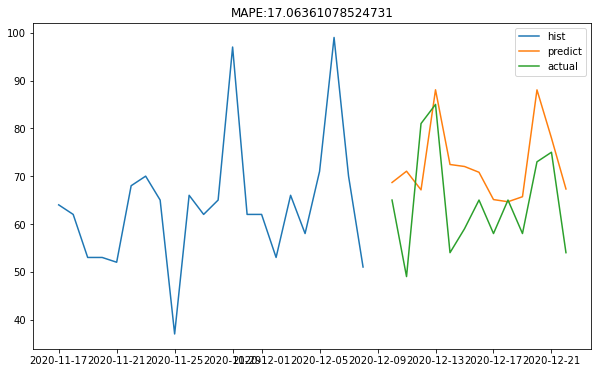

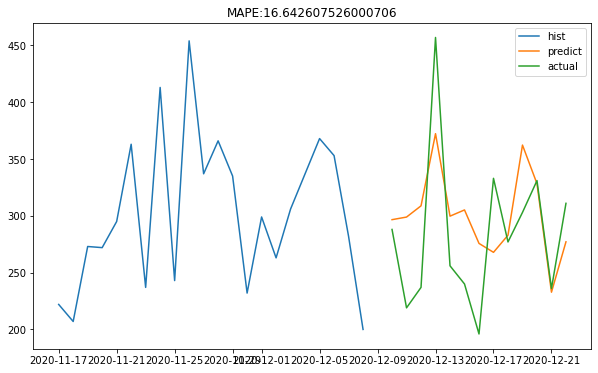

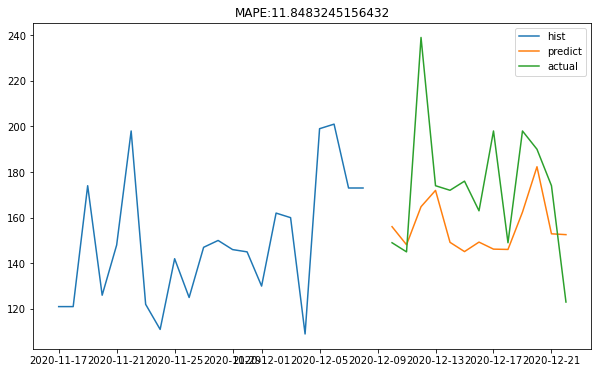

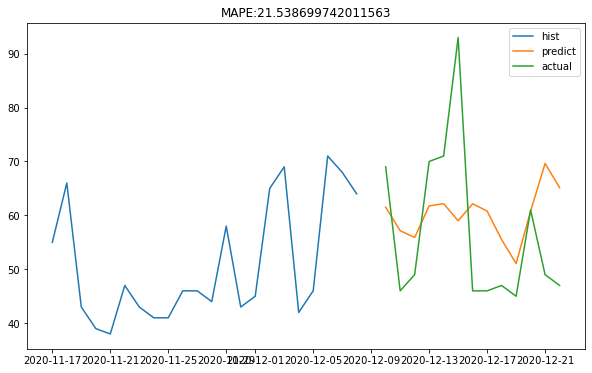

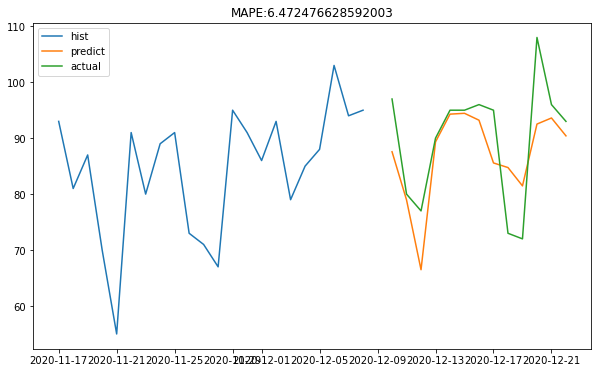

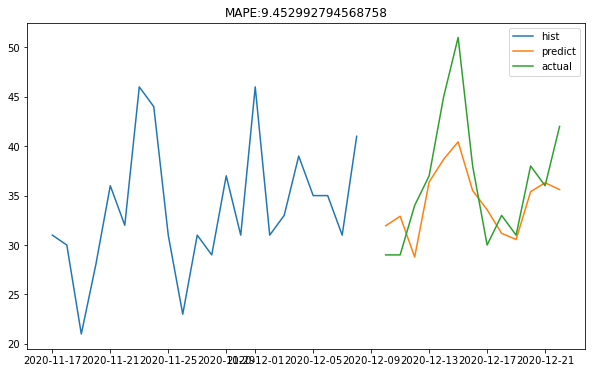

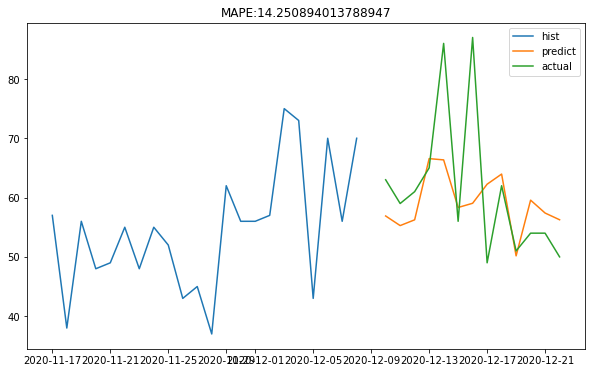

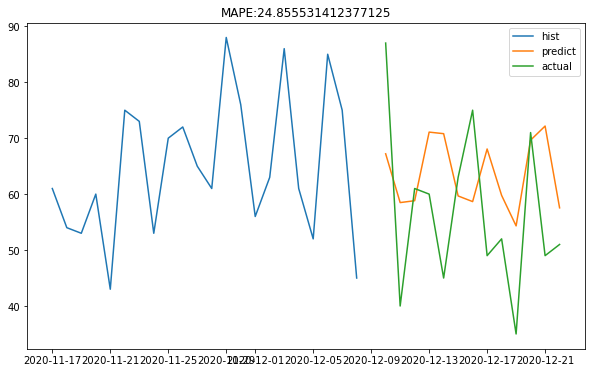

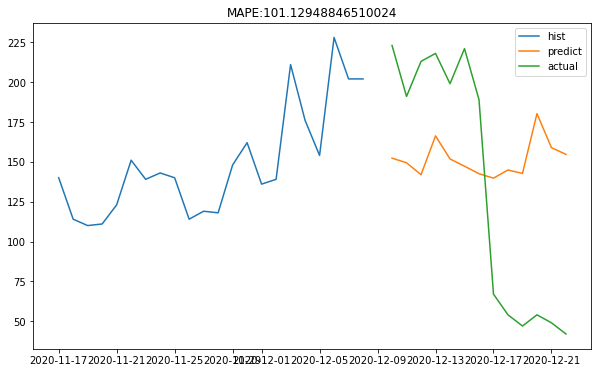

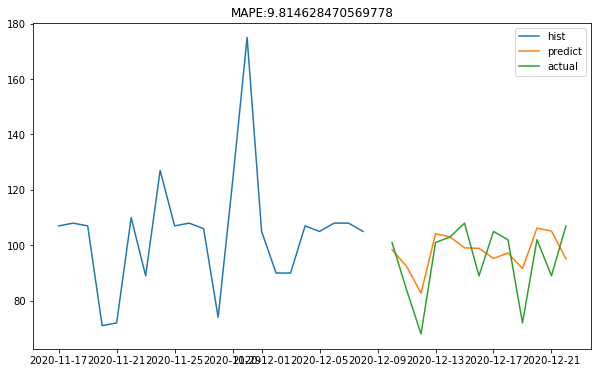

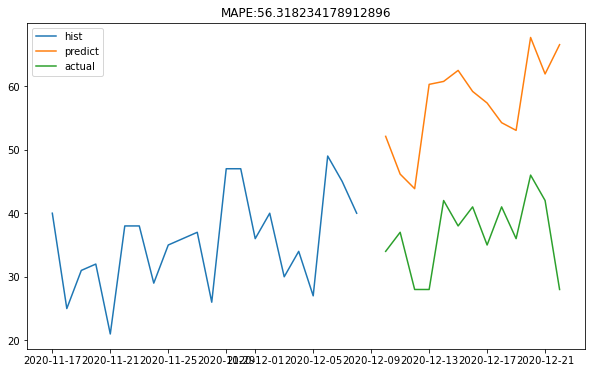

In [ ]:
hist = df_train[df_train["Date"]>"2020-11-15"]
for i in range(50):
    plt.figure(figsize=(10,6))
    plt.plot(hist["Date"][i*23+1:i*23+23],hist['QTY'][i*23+1:i*23+23],label="hist")
    plt.plot(df_final["Date"][i*14+1:i*14+14],df_final['yhat'][i*14+1:i*14+14],label="predict")
    plt.plot(df_final["Date"][i*14+1:i*14+14],df_final['QTY'][i*14+1:i*14+14],label="actual")
    plt.title("MAPE:" + str(MAPE_indi[i]*100))
    plt.legend()